In [1]:
!mkdir data

mkdir: data: File exists


In [2]:
!wget https://www.dropbox.com/s/cwlaaxl70t27tb2/data_tutorial_buenrostro.tar.gz?dl=0 -O data/data_tutorial_buenrostro.tar.gz

zsh:1: no matches found: https://www.dropbox.com/s/cwlaaxl70t27tb2/data_tutorial_buenrostro.tar.gz?dl=0


In [3]:
!wget https://www.dropbox.com/s/cwlaaxl70t27tb2/data_tutorial_buenrostro.tar.gz?dl=0 -O data_tutorial_buenrostro.tar.gz

zsh:1: no matches found: https://www.dropbox.com/s/cwlaaxl70t27tb2/data_tutorial_buenrostro.tar.gz?dl=0


In [4]:
!cd data; tar -xzf data_tutorial_buenrostro.tar.gz

In [5]:
!mkdir write

In [ ]:
sc.__version__

# Load libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import episcanpy.api as epi

In [2]:
sc.settings.set_figure_params(dpi=80, color_map='gist_earth')

In [3]:
results_file = 'data/mca_Cerebellum_62216.h5ad'  # the file that will store the analysis results

# Load the data

In [61]:
adata = ad.read('data/mca_Cerebellum_62216.h5ad')
adata

AnnData object with n_obs × n_vars = 2278 × 436206
    obs: 'cell_type'
    var: 'peak'

In [62]:
adata.obs

cell_type
0                  Unknown
1                  Unknown
2                  Unknown
3                  Unknown
4                  Unknown
...                    ...
2273  Endothelial II cells
2274  Endothelial II cells
2275  Endothelial II cells
2276  Endothelial II cells
2277  Endothelial II cells

[2278 rows x 1 columns]

In [63]:
adata.var['peak']

0         chr1_3002478_3002968
1         chr1_3084739_3085712
2         chr1_3103576_3104022
3         chr1_3106871_3107210
4         chr1_3108932_3109158
                  ...         
436201      chrY_621772_623366
436202      chrY_629871_630911
436203      chrY_631222_631480
436204      chrY_795887_796426
436205    chrY_2397419_2397628
Name: peak, Length: 436206, dtype: object

In [64]:
adata.obs['cell_type']

0                    Unknown
1                    Unknown
2                    Unknown
3                    Unknown
4                    Unknown
                ...         
2273    Endothelial II cells
2274    Endothelial II cells
2275    Endothelial II cells
2276    Endothelial II cells
2277    Endothelial II cells
Name: cell_type, Length: 2278, dtype: category
Categories (20, object): ['Astrocytes', 'B cells', 'Cerebellar granule cells', 'Collisions', ..., 'Podocytes', 'Purkinje cells', 'SOM+ Interneurons', 'Unknown']

# Preprocessing

In [65]:
print(np.max(adata.X))

1.0


In [66]:
Binarization = True
if Binarization:
    epi.pp.binarize(adata)
    print(adata)

AnnData object with n_obs × n_vars = 2278 × 436206
    obs: 'cell_type'
    var: 'peak'


In [67]:
adata.X

<2278x436206 sparse matrix of type '<class 'numpy.float32'>'
	with 8170281 stored elements in Compressed Sparse Column format>

In [68]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)

In [69]:
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
adata

AnnData object with n_obs × n_vars = 2278 × 427056
    obs: 'cell_type', 'nb_features', 'log_nb_features'
    var: 'peak', 'n_cells'

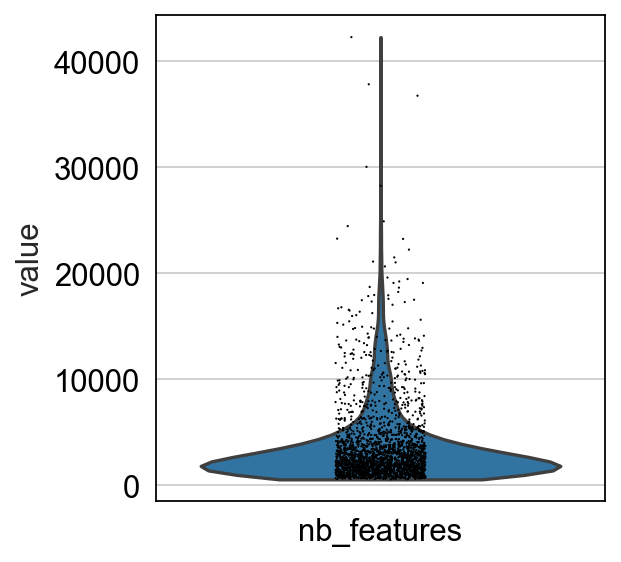

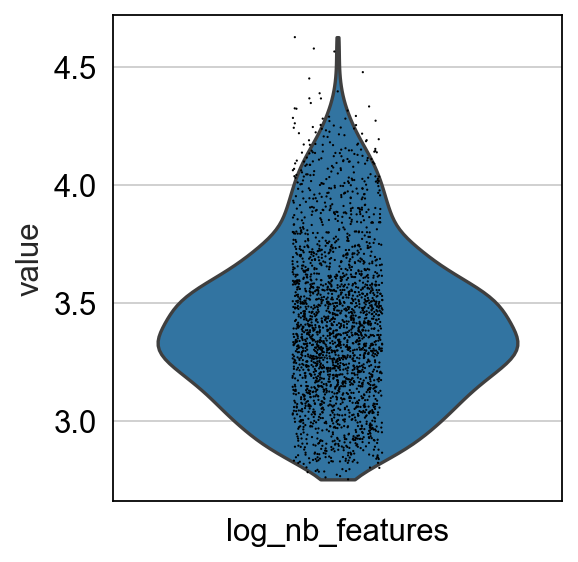

In [70]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

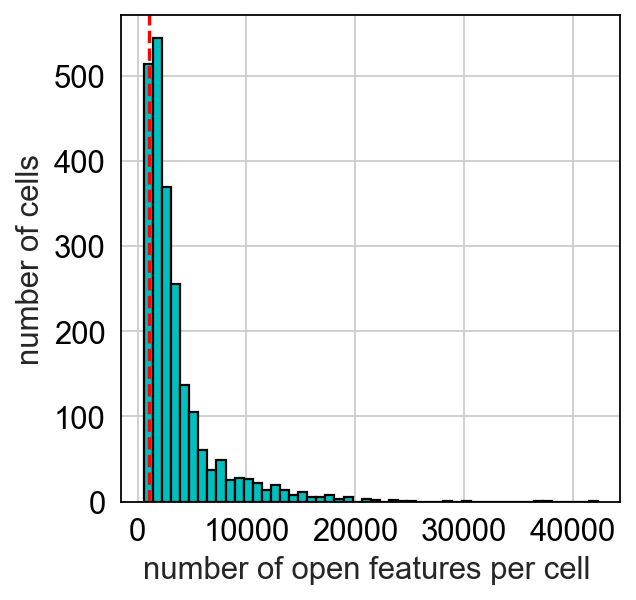

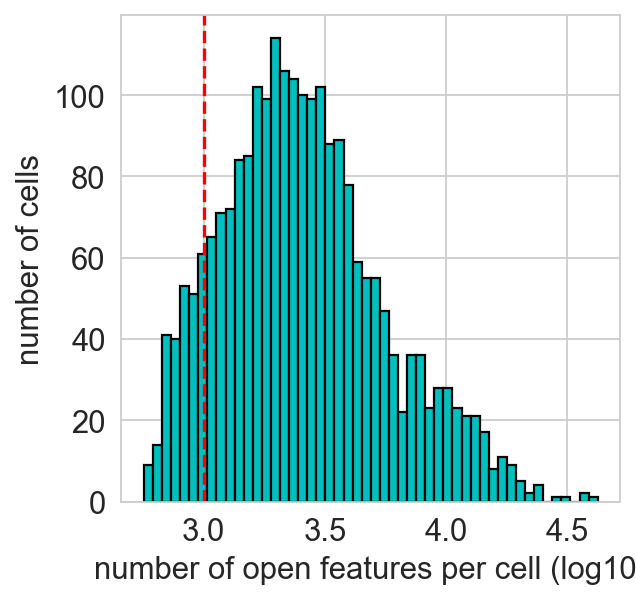

In [71]:
# set a minimum number of cells to keep 
min_features = 1000

epi.pp.coverage_cells(adata, binary=True, log=False, bins=50,
               threshold=min_features, save='Buenrostro_bulk_peaks_coverage_cells.png')
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50,
               threshold=min_features, save='Buenrostro_bulk_peaks_coverage_cells_log10.png')

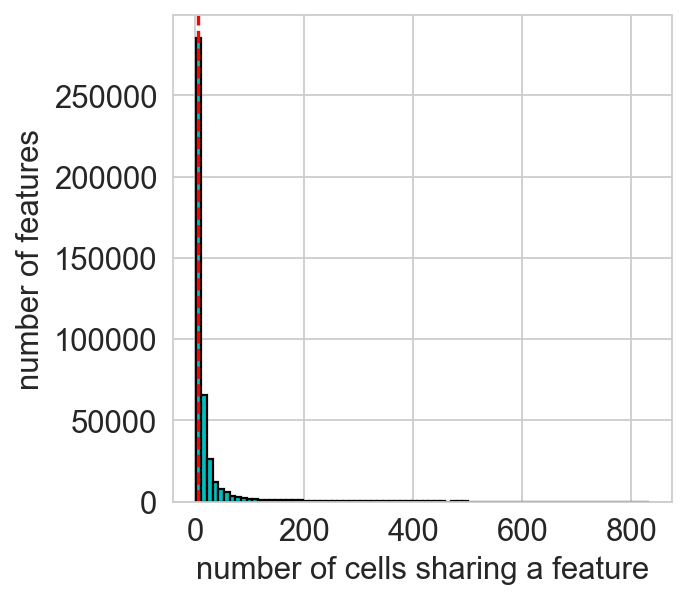

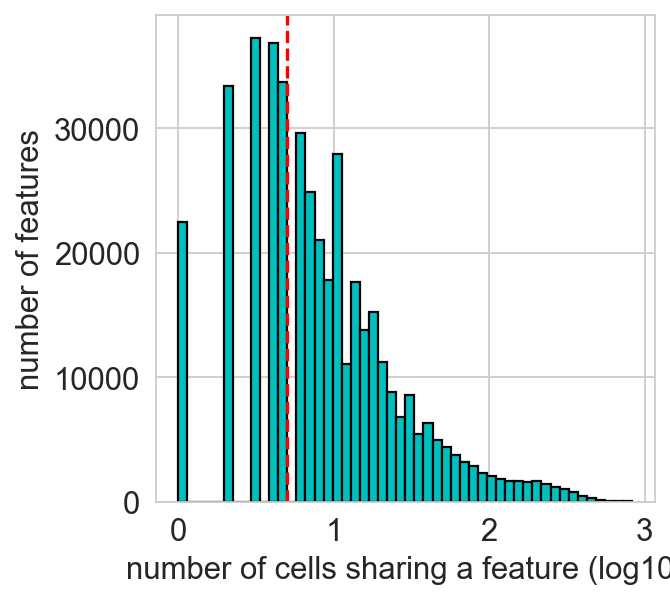

In [72]:
# minimum number of cells sharing a feature
min_cells = 5
epi.pp.coverage_features(adata, binary=True, log=False, 
                        threshold=min_cells, save='Buenrostro_bulk_peaks_coverage_peaks.png')
epi.pp.coverage_features(adata, binary=True, log=True, 
                        threshold=min_cells, save='Buenrostro_bulk_peaks_coverage_peaks_log10.png')

Actually proceed to filter the cells and peaks based on the QC plots

In [73]:
min_features = 1000
epi.pp.filter_cells(adata, min_features=min_features)
adata

AnnData object with n_obs × n_vars = 2035 × 427056
    obs: 'cell_type', 'nb_features', 'log_nb_features'
    var: 'peak', 'n_cells', 'commonness'

In [74]:
min_cells = 5
epi.pp.filter_features(adata, min_cells=min_cells)
adata

AnnData object with n_obs × n_vars = 2035 × 292668
    obs: 'cell_type', 'nb_features', 'log_nb_features'
    var: 'peak', 'n_cells', 'commonness'

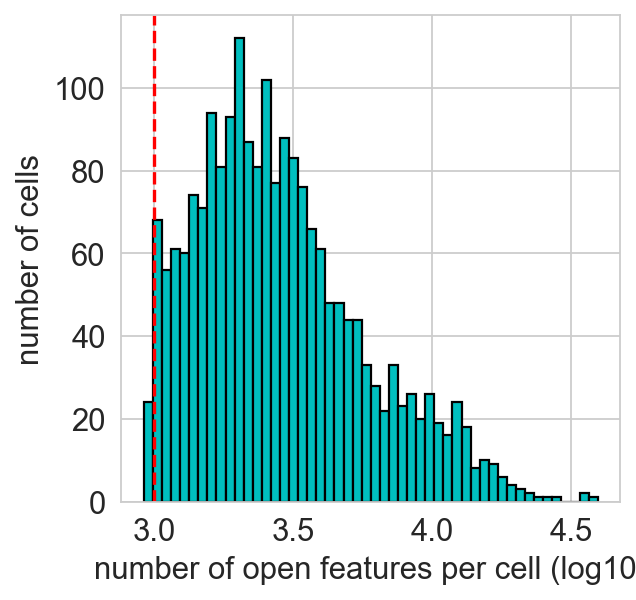

In [75]:
epi.pp.coverage_cells(adata, binary=True, log='log10', bins=50, threshold=min_features)

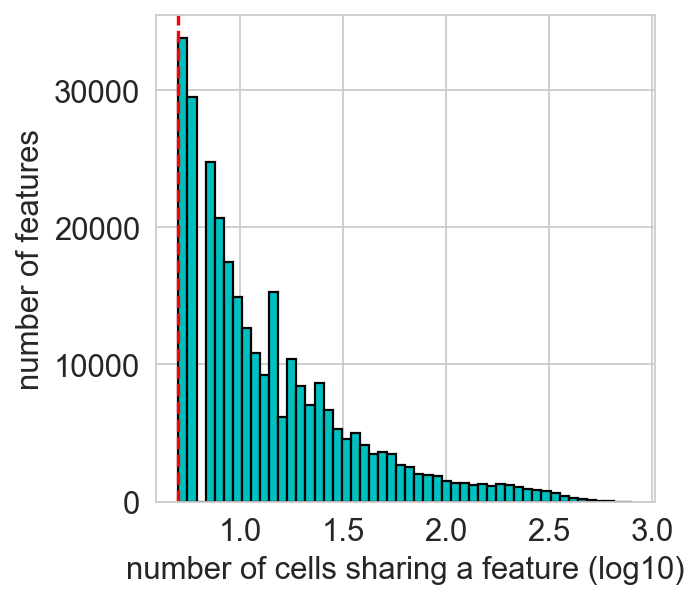

In [76]:
epi.pp.coverage_features(adata, binary=True, log='log10', bins=50, threshold=min_cells)

# Identifying the most variable features

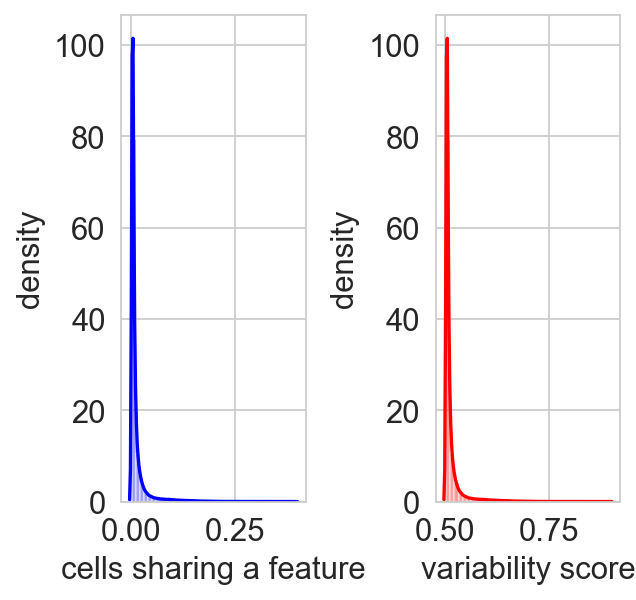

In [77]:
epi.pp.cal_var(adata)

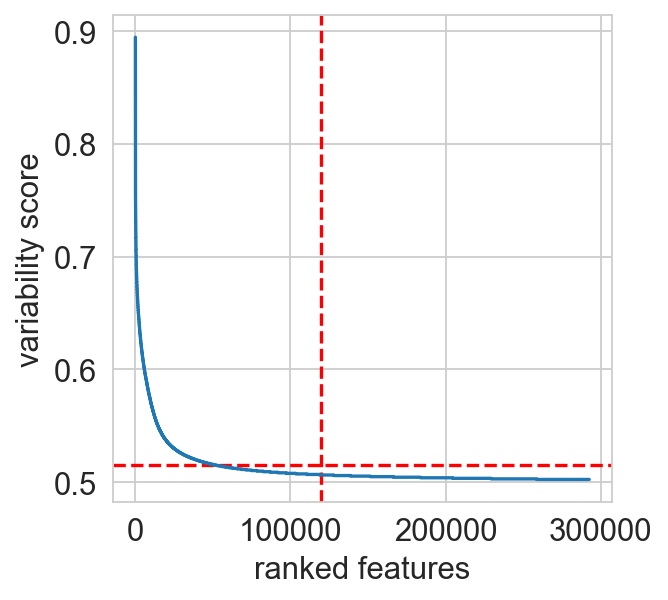

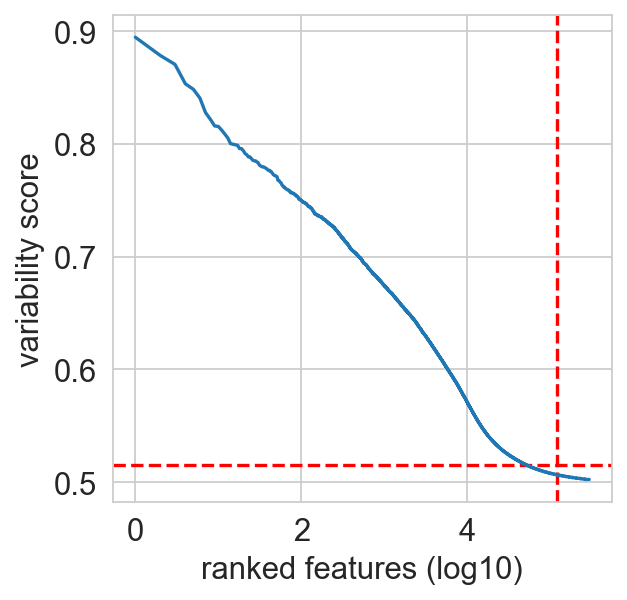

In [78]:
min_score_value = 0.515
nb_feature_selected = 120000
epi.pl.variability_features(adata,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_bonemarrow_peakmatrix.png')

epi.pl.variability_features(adata,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_bonemarrow_peakmatrix_log10.png')

In [79]:
# save the current matrix in the raw layer
adata.raw = adata

In [80]:
# create a new AnnData containing only the most variable features
adata = epi.pp.select_var_feature(adata,
                                  nb_features=nb_feature_selected,
                                  show=False,
                                  copy=True)

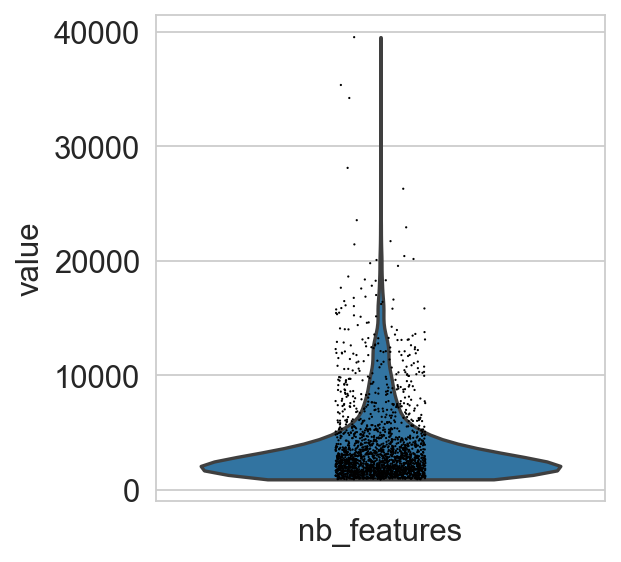

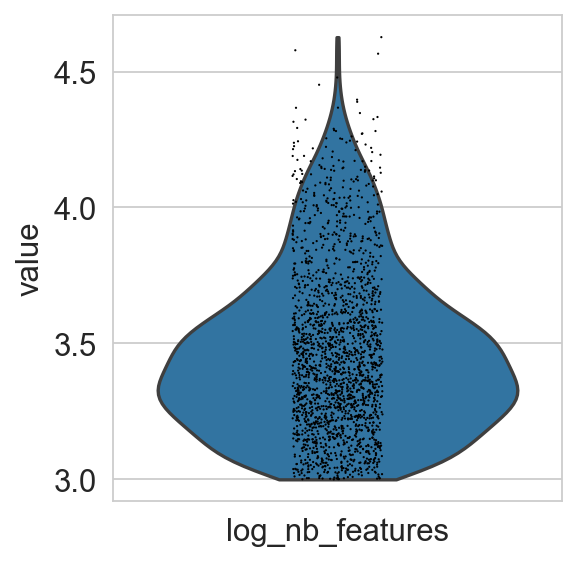

In [81]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

In [82]:
epi.pp.filter_cells(adata, min_features=2000)
epi.pp.filter_cells(adata, max_features=25000)

Trying to set attribute `.obs` of view, copying.


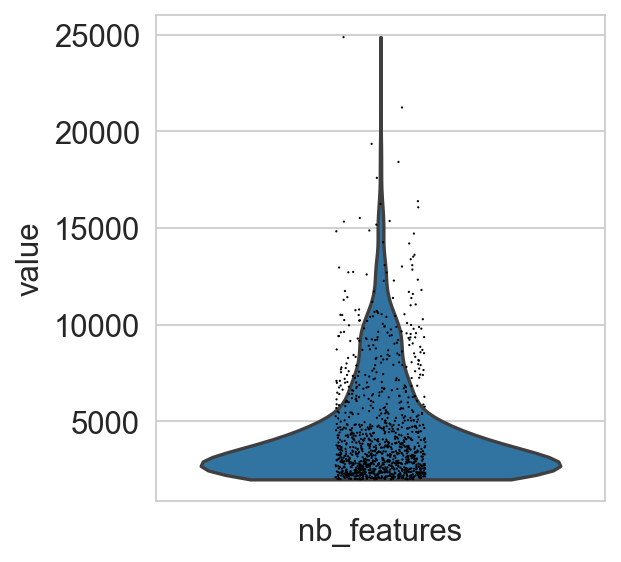

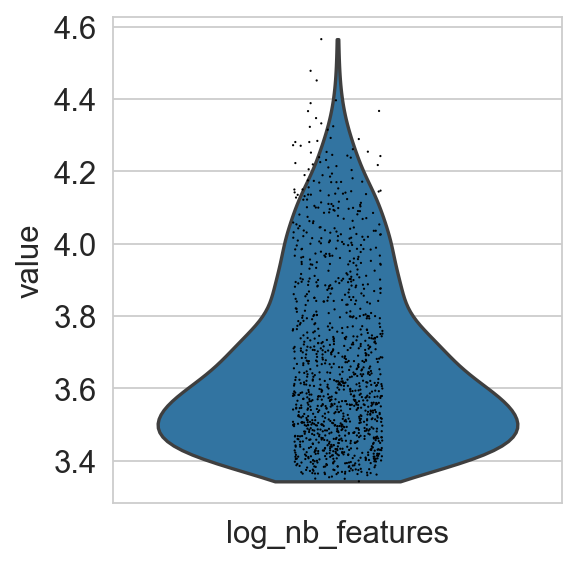

In [83]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

# Normalisation

In [84]:
adata

AnnData object with n_obs × n_vars = 1125 × 127969
    obs: 'cell_type', 'nb_features', 'log_nb_features'
    var: 'peak', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [85]:
# copy the current ann data
adata_copy = adata

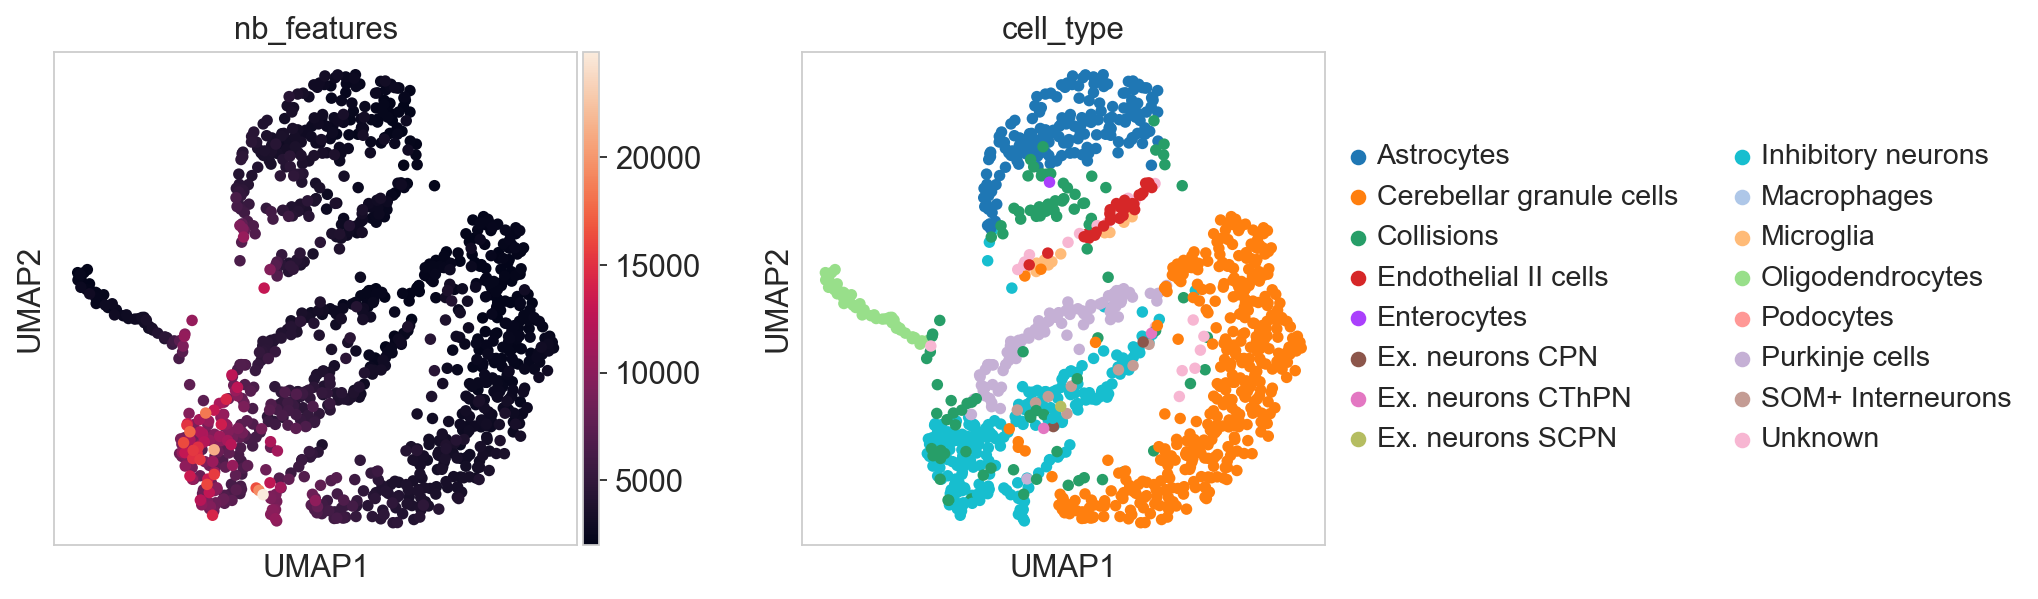

In [86]:
epi.pp.lazy(adata)
sc.pl.umap(adata, color=['nb_features', 'cell_type'], wspace=0.3)

In [87]:
# save the current version of the matrix (binary, not normalised) in a layer of the Anndata.
adata.layers['binary'] = adata.X.copy()

In [88]:
epi.pp.normalize_total(adata)
adata.layers['normalised'] = adata.X.copy()

# Visualization

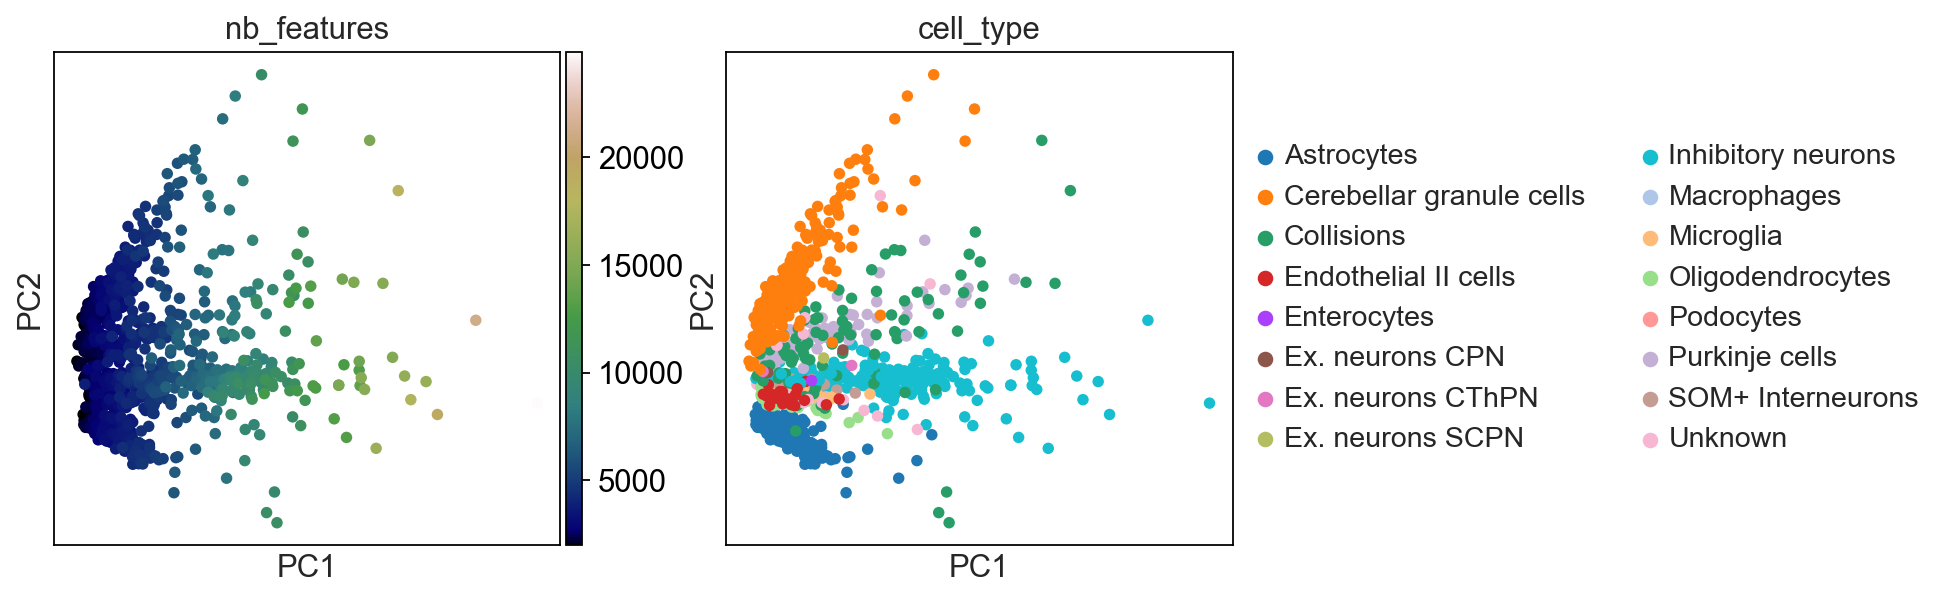

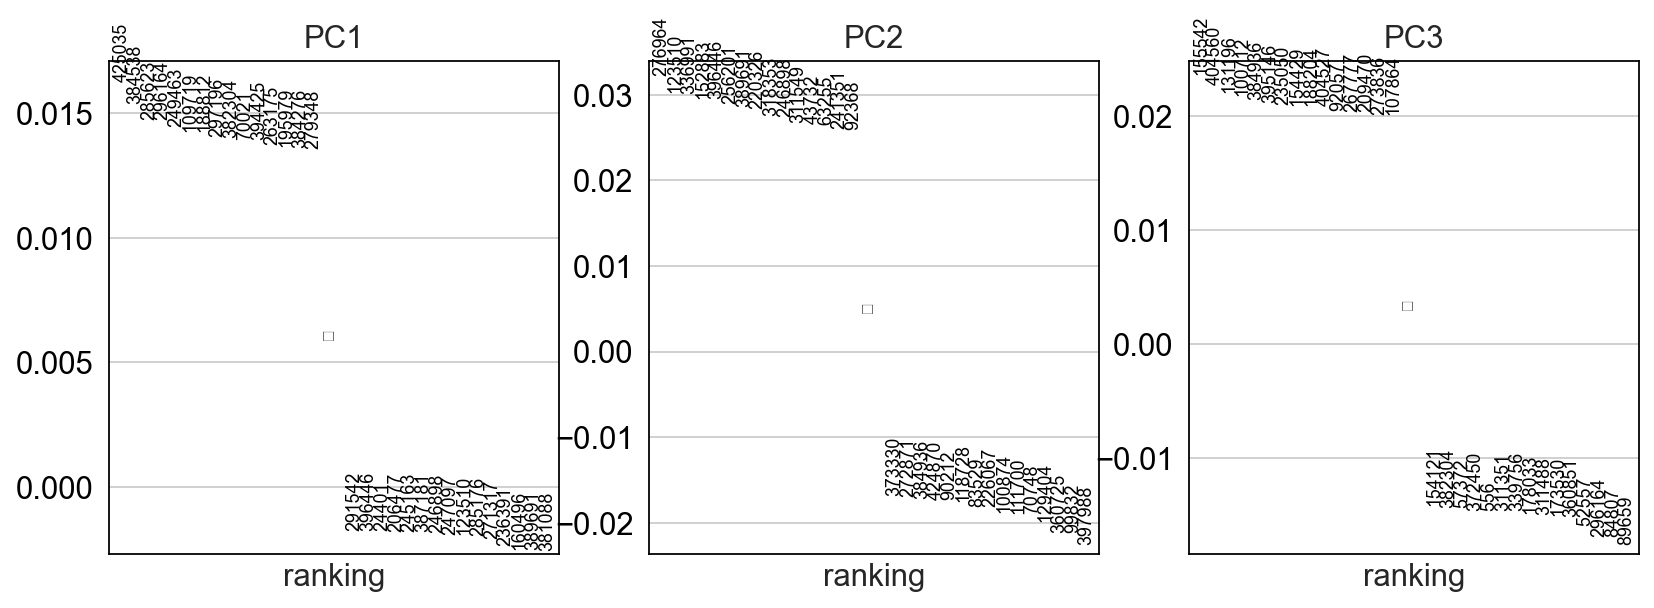

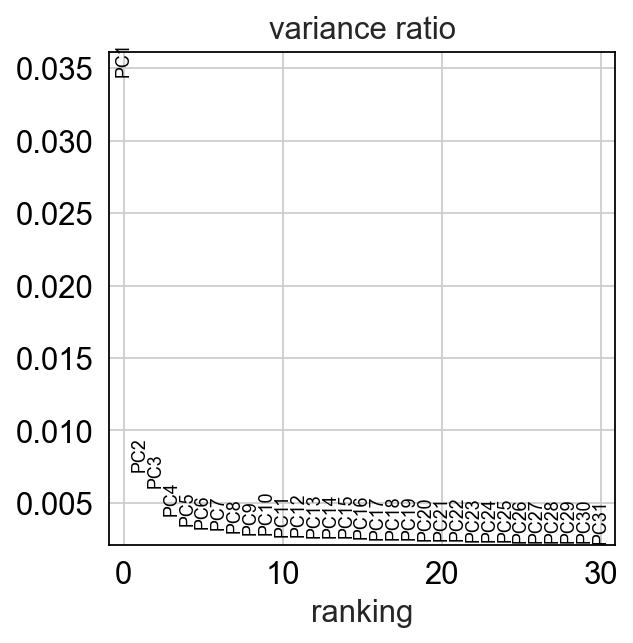

In [89]:
sc.settings.set_figure_params(dpi=80, color_map='gist_earth')
epi.pl.pca_overview(adata, color=['nb_features', 'cell_type'])

In [90]:
epi.pp.lazy(adata)

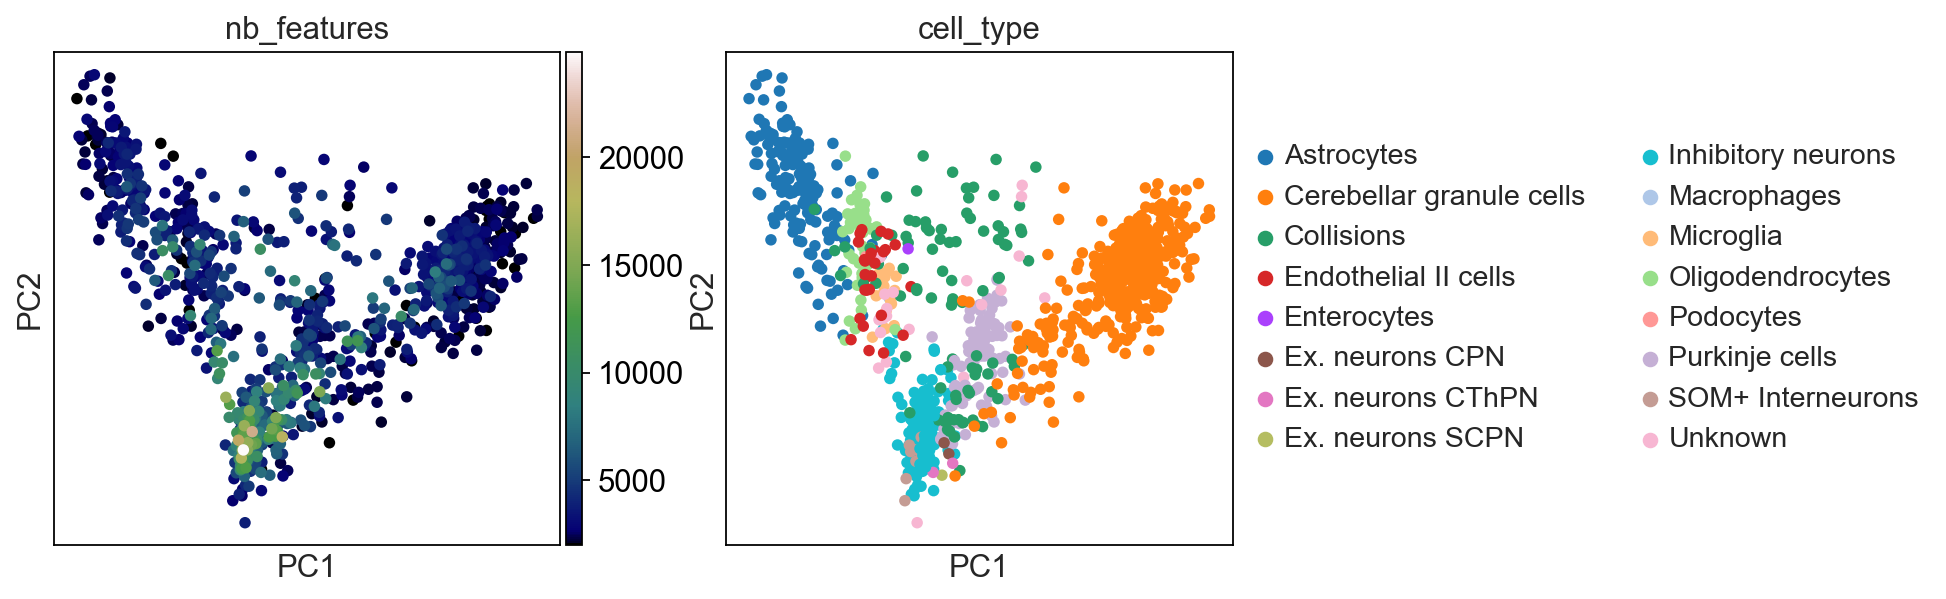

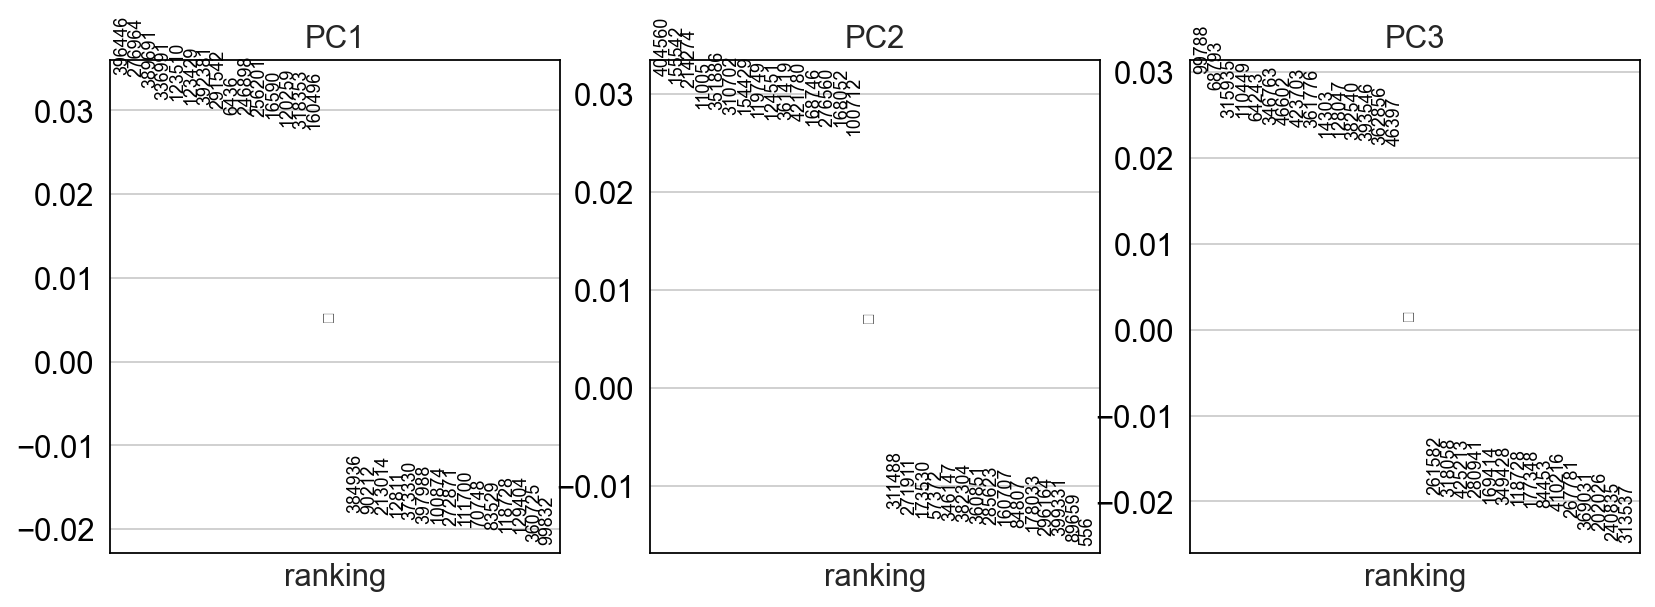

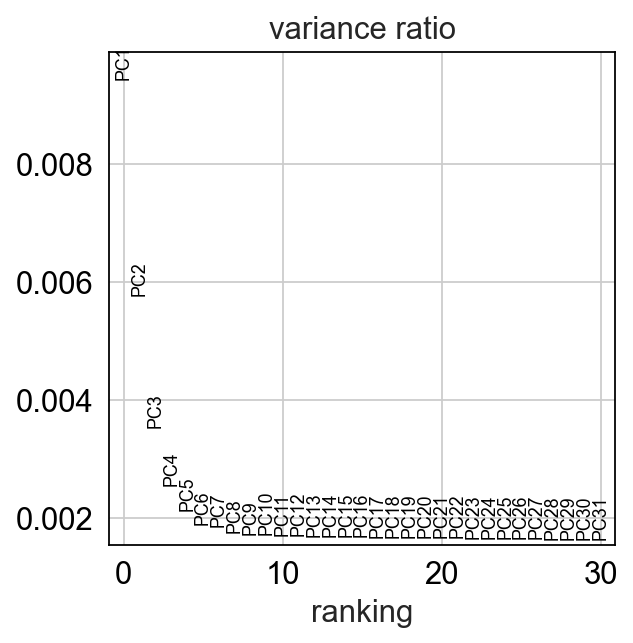

In [91]:
epi.pl.pca_overview(adata, color=['nb_features', 'cell_type'])

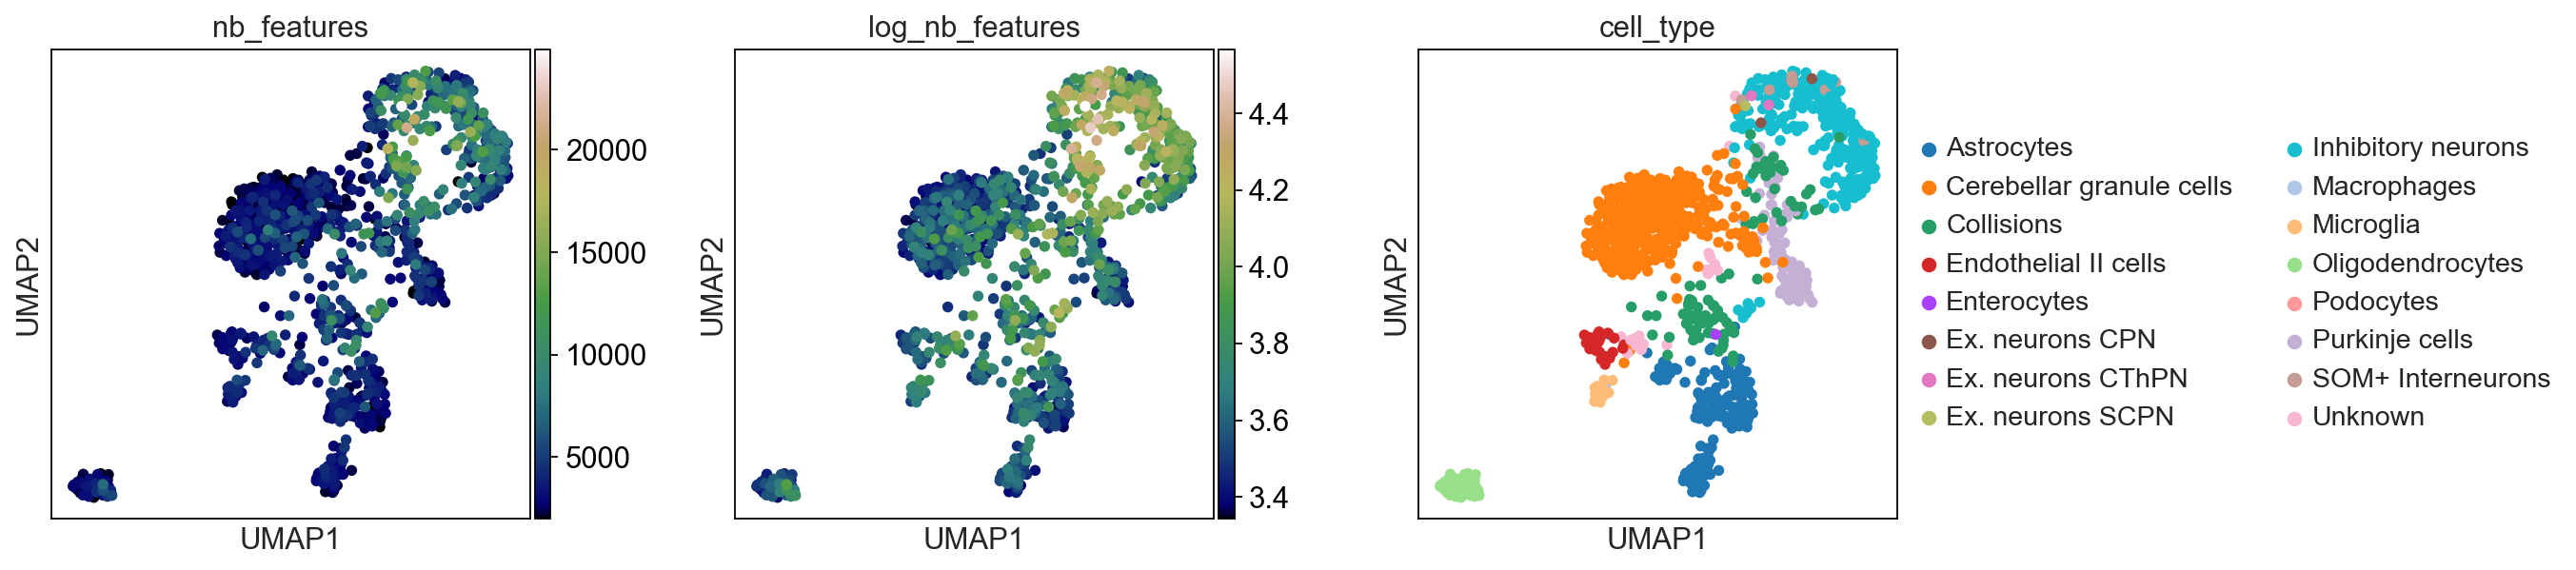

In [92]:
epi.pl.umap(adata, color=['nb_features', 'log_nb_features', 'cell_type'], wspace=0.3)

# Log transform

In [93]:
epi.pp.log1p(adata)

In [94]:
epi.pp.lazy(adata)

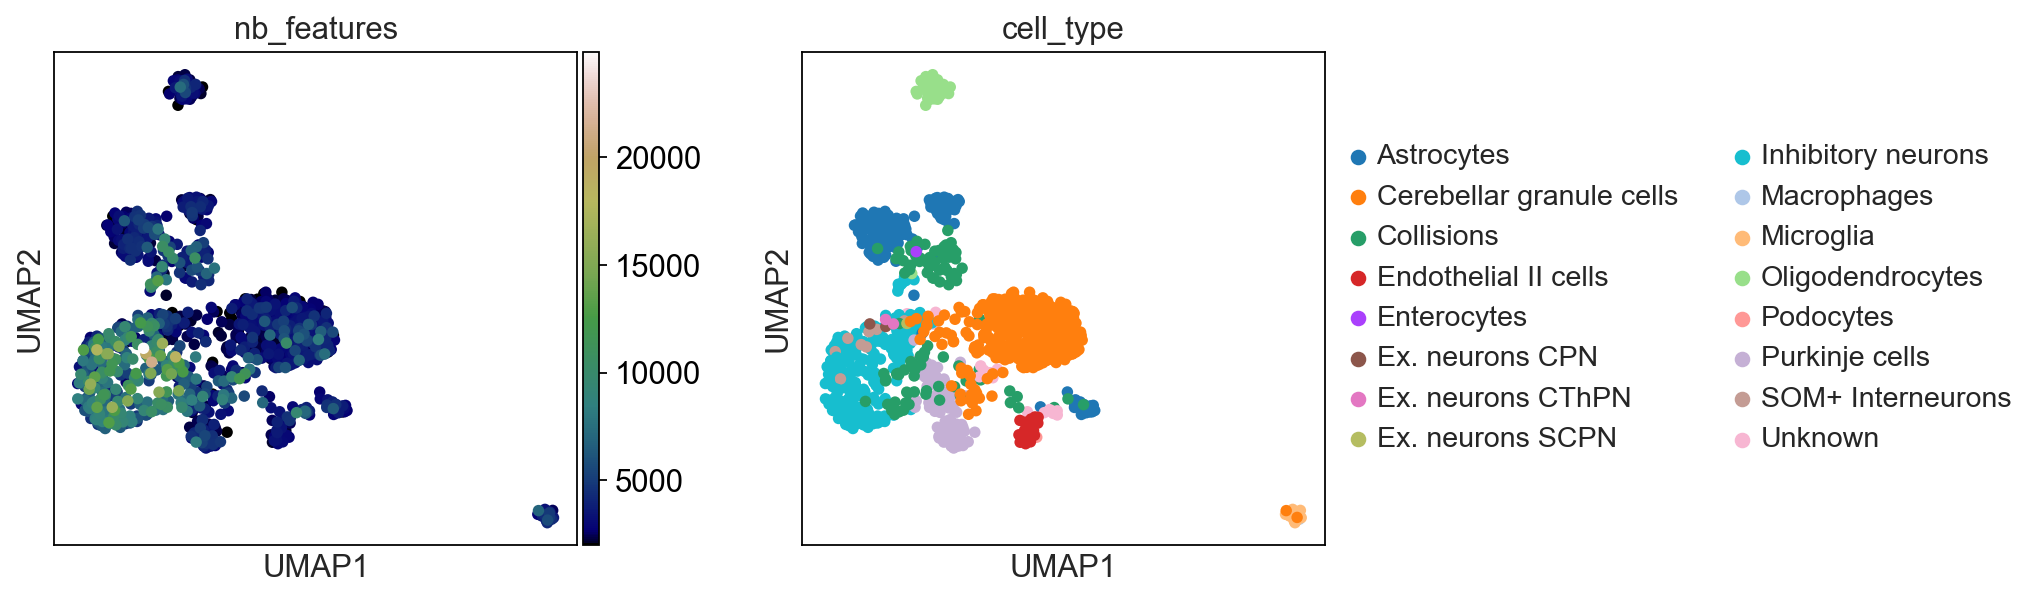

In [95]:
epi.pl.umap(adata, color=['nb_features', 'cell_type'], wspace=0.3)

# refProj methods

In [39]:
regions = adata.var['peak']
regions = [i.split('_') for i in regions]
for region in regions:
    region.extend(['.','.','.'])

In [131]:
filename = 'mca_Cerebellum_62216.bed'
with open (filename,'w') as file_object:
    for line in regions:
        file_object.write('\t'.join(line) + "\n")   

In [132]:
from OpenAnnotatePy import OpenAnnotateApi

In [133]:
oaa=OpenAnnotateApi.Annotate()

Use object.help() to get basic functions and arguments


In [134]:
oaa.SetAddress('159.226.47.242','65533')

In [135]:
oaa.setParams(species = 3, protocol=1, cell_type=1, perbase=1)

Species:  GRCm37/mm9
Protocol:  DNase-seq(ENCODE)
Cell type: 
All biosamples
Annotate mode:  region based


In [136]:
file_path = './mca_Cerebellum_62216.bed'
task_id=oaa.runAnnotate(file_path)

Uploading...
Initializing...
Your task id is: 2023120321133972
You can get the progress of your task through object.getProgress(task_id=2023120321133972)


In [137]:
oaa.getProgress(task_id)

Your task has been completed!
You can get the result file type first through object.getResultType()
You can download result file through data = object.getAnnoResult(result_type, 2023120321133972)


In [138]:
oaa.getAnnoResult(3,task_id,1)
oaa.getAnnoResult(2,task_id,1)

Get the result to ./results/peakopen_2023120321133972.txt
Get the result to ./results/readopen_2023120321133972.txt


In [45]:
peakopen = np.loadtxt('./results/peakopen_%s.txt'%task_id,dtype = str)
peakopen = peakopen[:,4:].astype(float)

readopen = np.loadtxt('./results/readopen_%s.txt'%task_id,dtype = str)
readopen = readopen[:,4:].astype(float)

In [46]:
print(readopen.shape)

(127969, 144)


In [47]:
from sklearn.feature_extraction.text import TfidfTransformer
import scipy

def TFIDF(sc_counts):
    model = TfidfTransformer(smooth_idf=False, norm="l2")
    model = model.fit(np.transpose(count_mat))
    model.idf_ -= 1
    tf_idf = np.transpose(model.transform(np.transpose(count_mat)))
    return scipy.sparse.csr_matrix(tf_idf)

In [49]:
from sklearn.decomposition import PCA
import umap
# Perform TF-IDF/
ref_pca_peak = PCA(random_state=2023,n_components = 50).fit(TFIDF(peakopen).toarray().T)
ref_pca_read = PCA(random_state=2023,n_components = 50).fit(TFIDF(readopen).toarray().T)

In [50]:
ref_pca_peak

PCA(n_components=50, random_state=2023)

In [96]:
sc_counts = adata.layers['binary'].toarray()
sc_counts = sc_counts.T
adata_ref = adata.copy()

In [98]:
sc_tfidf_refProj_peak = ref_pca_peak.transform(TFIDF(sc_counts).toarray().T)
sc_tfidf_refProj_read = ref_pca_read.transform(TFIDF(sc_counts).toarray().T)

In [102]:
from scipy import stats
from sklearn.preprocessing import StandardScaler

adata = adata_ref.copy()
temp_pca = adata_ref.obsm['X_pca'].copy()
adata_zscore = adata_ref.copy()
adata_ref_all = adata_ref.copy()
adata_ref_peak = adata_ref.copy()
adata_ref_read = adata_ref.copy()
adata_ref_all.obsm['X_pca'] = np.hstack((temp_pca[:,:50],sc_tfidf_refProj_peak[:,:50],sc_tfidf_refProj_read[:,:50]))
adata_ref_peak.obsm['X_pca'] = np.hstack((temp_pca[:,:50],sc_tfidf_refProj_peak[:,:50]))
adata_ref_read.obsm['X_pca'] = np.hstack((temp_pca[:,:50],sc_tfidf_refProj_read[:,:50]))
adata_zscore.obsm['X_pca'] = sc_tfidf_refProj_read[:,:50]


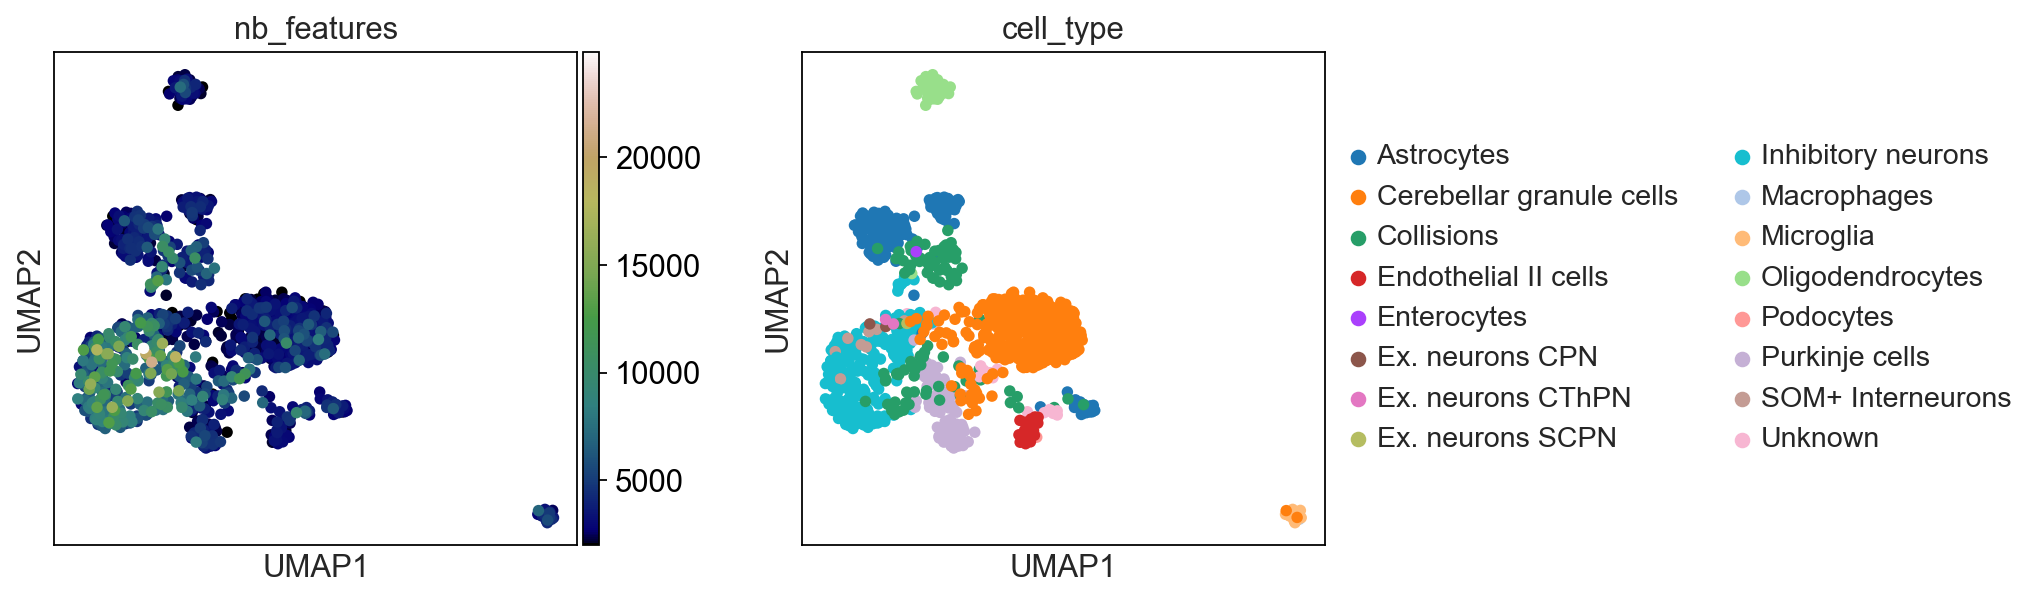

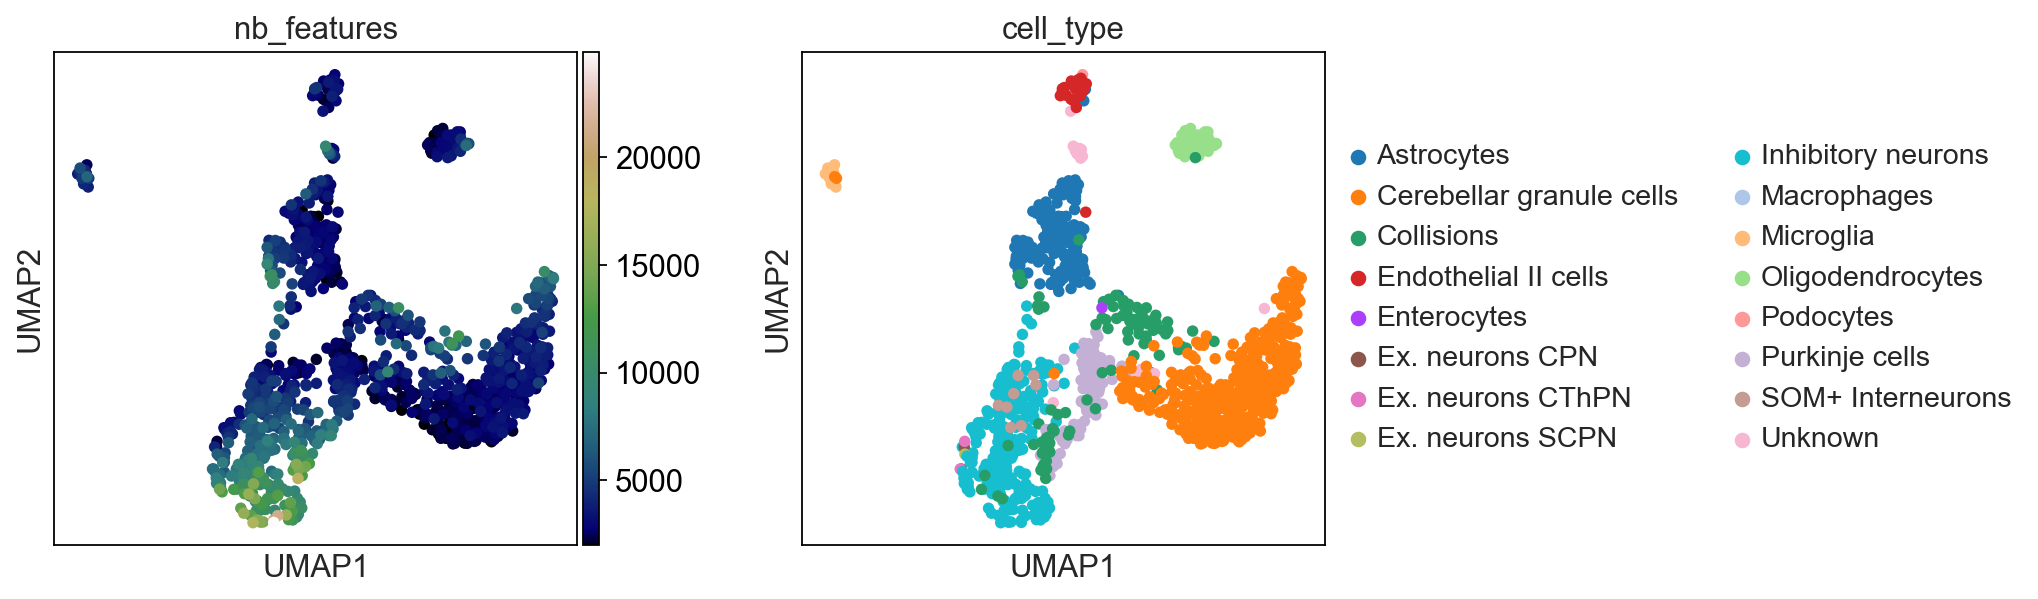

In [103]:
epi.pp.lazy(adata,pp_pca=False,nb_pcs=50)
sc.pl.umap(adata, color=['nb_features', 'cell_type'], wspace=0.3,save='mca_Cerebellum_62216_origin.png')


# epi.pp.lazy(adata_zscore,pp_pca=False,nb_pcs=50)
# sc.pl.umap(adata_zscore, color=['nb_features', 'cell_type'], wspace=0.3)


# epi.pp.lazy(adata_ref_all,pp_pca=False,nb_pcs=150)
# sc.pl.umap(adata_ref_all, color=['nb_features', 'cell_type'], wspace=0.3)

epi.pp.lazy(adata_ref_peak,pp_pca=False,nb_pcs=50)
sc.pl.umap(adata_ref_peak, color=['nb_features', 'cell_type'], wspace=0.3,save='mca_Cerebellum_62216_peakopen.png')
# plt.savefig('mca_Cerebellum_62216_peakopen.png', dpi=300)  # 以 300 DPI 的分辨率保存为 PNG 文件

# epi.pp.lazy(adata_ref_read,pp_pca=False,nb_pcs=100)
# sc.pl.umap(adata_ref_read, color=['nb_features', 'cell_type'], wspace=0.3)

# Cell Cluster

## Clustering with fixed cluster num=14

In [104]:
# different cluster methods & different dimention reduction method
num_cluster = 16

epi.tl.getNClusters(adata_zscore, n_cluster=num_cluster,method='louvain')
epi.tl.kmeans(adata_zscore, num_clusters=num_cluster)
epi.tl.hc(adata_zscore, num_clusters=num_cluster)
epi.tl.getNClusters(adata_zscore, n_cluster=num_cluster, method='leiden')


epi.tl.getNClusters(adata, n_cluster=num_cluster,method='louvain')
epi.tl.kmeans(adata, num_clusters=num_cluster)
epi.tl.hc(adata, num_clusters=num_cluster)
epi.tl.getNClusters(adata, n_cluster=num_cluster, method='leiden')

# epi.tl.louvain(adata_ref_all)
epi.tl.getNClusters(adata_ref_all, n_cluster=num_cluster,method='louvain')
epi.tl.kmeans(adata_ref_all, num_clusters=num_cluster)
epi.tl.hc(adata_ref_all, num_clusters=num_cluster)
epi.tl.getNClusters(adata_ref_all, n_cluster=num_cluster, method='leiden')

epi.tl.getNClusters(adata_ref_peak, n_cluster=num_cluster,method='louvain')
epi.tl.kmeans(adata_ref_peak, num_clusters=num_cluster)
epi.tl.hc(adata_ref_peak, num_clusters=num_cluster)
epi.tl.getNClusters(adata_ref_peak, n_cluster=num_cluster, method='leiden')

epi.tl.getNClusters(adata_ref_read, n_cluster=num_cluster,method='louvain')
epi.tl.kmeans(adata_ref_read, num_clusters=num_cluster)
epi.tl.hc(adata_ref_read, num_clusters=num_cluster)
epi.tl.getNClusters(adata_ref_read, n_cluster=num_cluster, method='leiden')

step 0
got 10 at resolution 1.5
step 1
got 14 at resolution 2.25
step 2
got 17 at resolution 2.625
step 3
got 17 at resolution 2.4375
step 4
got 14 at resolution 2.34375
step 5
got 16 at resolution 2.390625
step 0
got 15 at resolution 1.5
step 1
got 18 at resolution 2.25
step 2
got 16 at resolution 1.875
step 0
got 10 at resolution 1.5
step 1
got 14 at resolution 2.25
step 2
got 17 at resolution 2.625
step 3
got 17 at resolution 2.4375
step 4
got 14 at resolution 2.34375
step 5
got 16 at resolution 2.390625
step 0
got 15 at resolution 1.5
step 1
got 18 at resolution 2.25
step 2
got 16 at resolution 1.875
step 0
got 10 at resolution 1.5
step 1
got 14 at resolution 2.25
step 2
got 17 at resolution 2.625
step 3
got 17 at resolution 2.4375
step 4
got 14 at resolution 2.34375
step 5
got 16 at resolution 2.390625
step 0
got 15 at resolution 1.5
step 1
got 18 at resolution 2.25
step 2
got 16 at resolution 1.875
step 0
got 15 at resolution 1.5
step 1
got 18 at resolution 2.25
step 2
got 17 at 

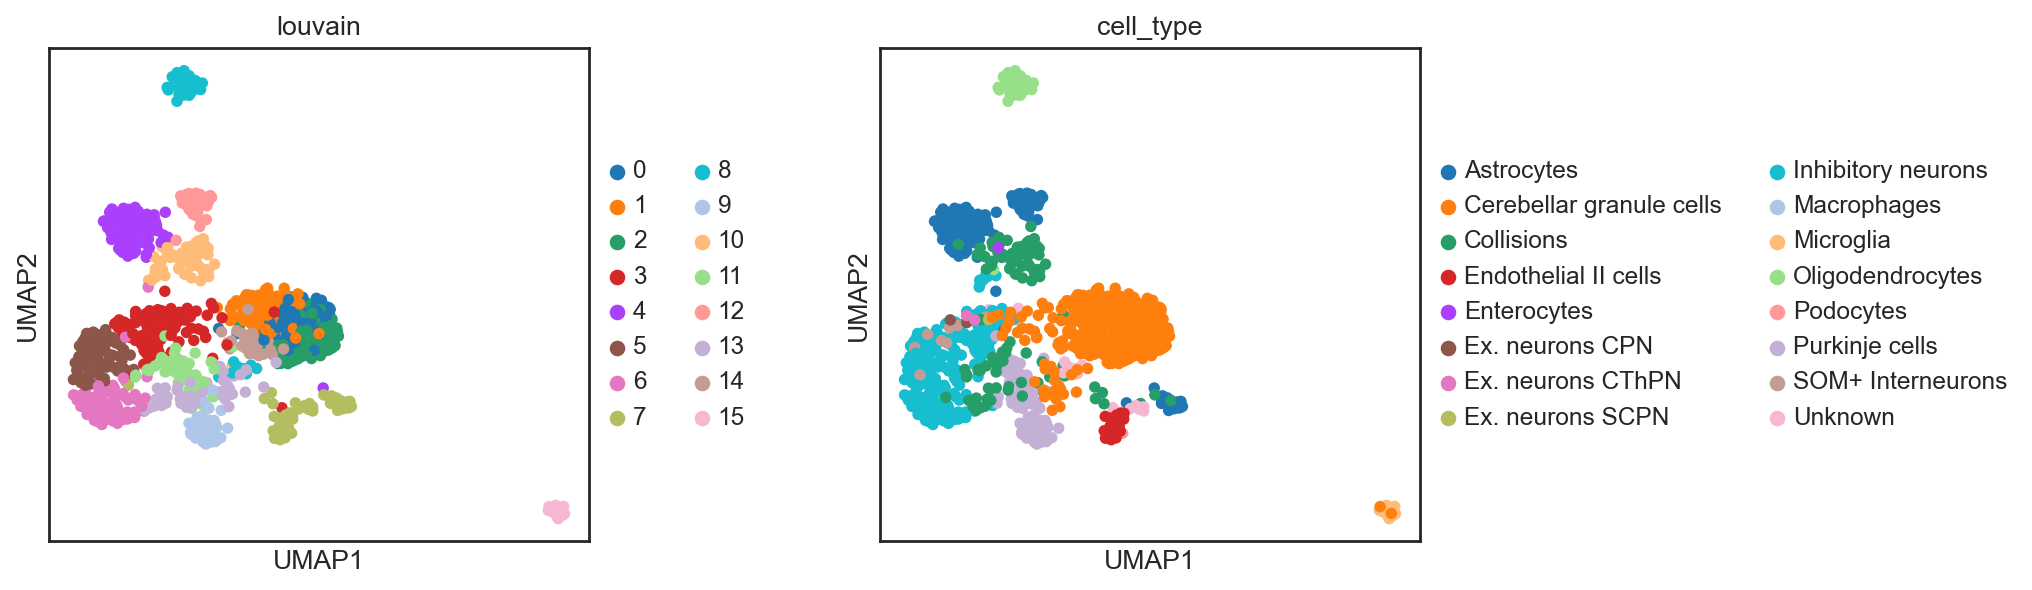

<Figure size 320x320 with 0 Axes>

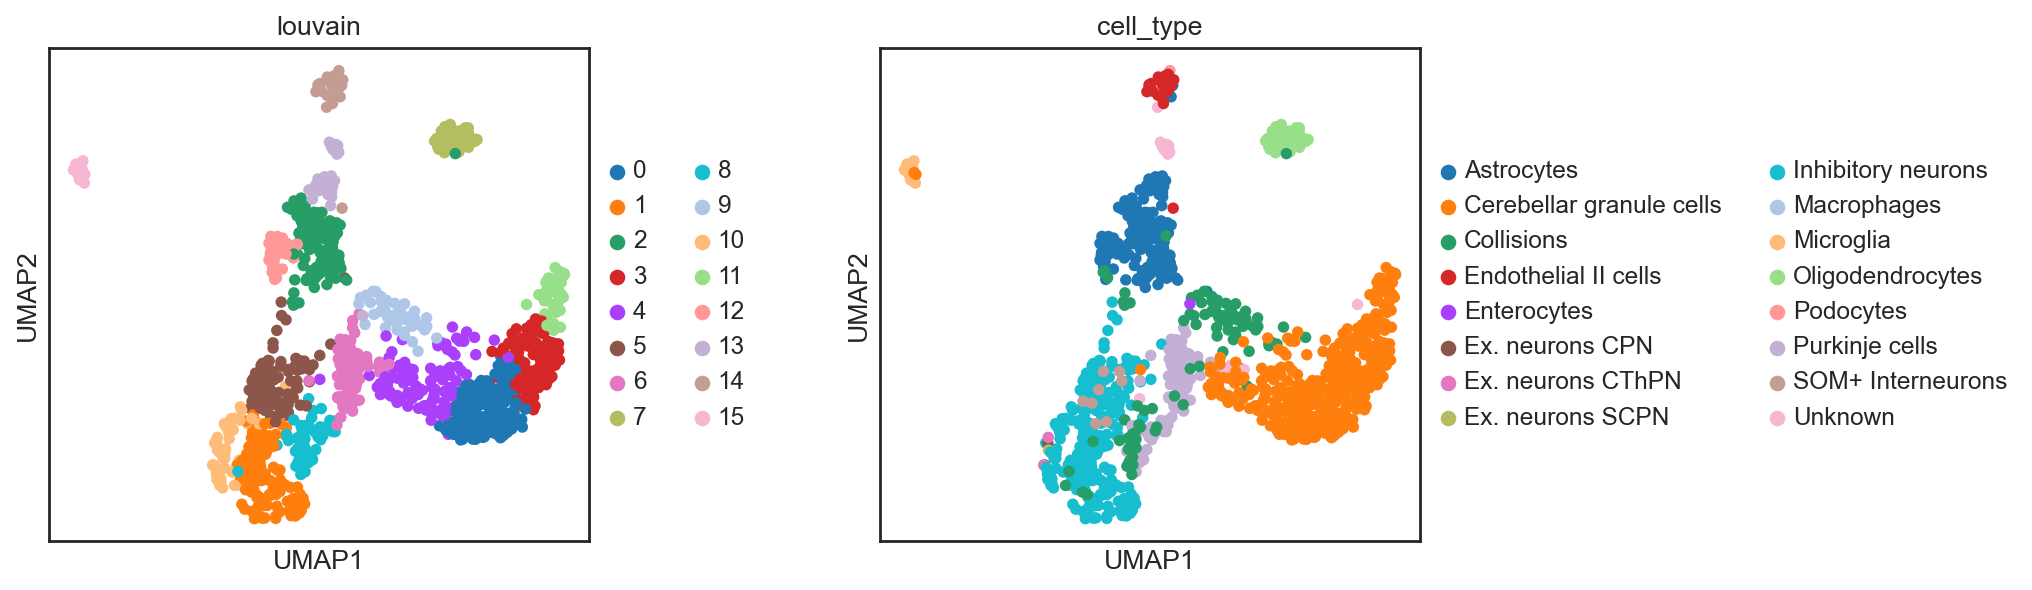

<Figure size 320x320 with 0 Axes>

In [79]:
epi.pl.umap(adata, color=['louvain', 'cell_type'], wspace=0.4)
plt.savefig('mca_Cerebellum_62216_origin.png', dpi=300)  # 以 300 DPI 的分辨率保存为 PNG 文件

epi.pl.umap(adata_ref_peak, color=['louvain', 'cell_type'], wspace=0.4)
plt.savefig('mca_Cerebellum_62216_peakopen.png', dpi=300)  # 以 300 DPI 的分辨率保存为 PNG 文件


### 1) Compute the Adjusted Rand Index for the different clustering to determine which one perform best. It computes a similarity measure between two clusterings (predicted and true labels)by counting cells that are assigned in the same or different clusters between the two clusterings.

In [61]:
# 0.1 ARI

# origin method
print('origin:')
print('louvain:\t', epi.tl.ARI(adata, 'louvain', 'cell_type'))
print('kmeans:\t', epi.tl.ARI(adata, 'kmeans', 'cell_type'))
print('hc:\t', epi.tl.ARI(adata, 'hc', 'cell_type'))
print('leiden:\t', epi.tl.ARI(adata, 'leiden', 'cell_type'))

# zscore method
print('origin with zscore:')
print('louvain:\t', epi.tl.ARI(adata_zscore, 'louvain', 'cell_type'))
print('kmeans:\t', epi.tl.ARI(adata_zscore, 'kmeans', 'cell_type'))
print('hc:\t', epi.tl.ARI(adata_zscore, 'hc', 'cell_type'))
print('leiden:\t', epi.tl.ARI(adata_zscore, 'leiden', 'cell_type'))

# reference method
print('reference peak:')
print('louvain:\t', epi.tl.ARI(adata_ref_peak, 'louvain', 'cell_type'))
print('kmeans:\t', epi.tl.ARI(adata_ref_peak, 'kmeans', 'cell_type'))
print('hc:\t', epi.tl.ARI(adata_ref_peak, 'hc', 'cell_type'))
print('leiden:\t', epi.tl.ARI(adata_ref_peak, 'leiden', 'cell_type'))

print('reference read:')
print('louvain:\t', epi.tl.ARI(adata_ref_read, 'louvain', 'cell_type'))
print('kmeans:\t', epi.tl.ARI(adata_ref_read, 'kmeans', 'cell_type'))
print('hc:\t', epi.tl.ARI(adata_ref_read, 'hc', 'cell_type'))
print('leiden:\t', epi.tl.ARI(adata_ref_read, 'leiden', 'cell_type'))

print('reference all:')
print('louvain:\t', epi.tl.ARI(adata_ref_all, 'louvain', 'cell_type'))
print('kmeans:\t', epi.tl.ARI(adata_ref_all, 'kmeans', 'cell_type'))
print('hc:\t', epi.tl.ARI(adata_ref_all, 'hc', 'cell_type'))
print('leiden:\t', epi.tl.ARI(adata_ref_all, 'leiden', 'cell_type'))

origin:
louvain:	 0.33615780533986306
kmeans:	 0.5232341126171826
hc:	 0.5386410042396961
leiden:	 0.4192941137612941
origin with zscore:
louvain:	 0.3072112700825765
kmeans:	 0.37384804986726605
hc:	 0.3703241406887236
leiden:	 0.436159478096849
reference peak:
louvain:	 0.427483643008882
kmeans:	 0.4563959334976071
hc:	 0.45711634424905134
leiden:	 0.44492167304107366
reference read:
louvain:	 0.33615780533986306
kmeans:	 0.5232341126171826
hc:	 0.5386410042396961
leiden:	 0.43676974776402855
reference all:
louvain:	 0.3166382035324509
kmeans:	 0.5232341126171826
hc:	 0.5386410042396961
leiden:	 0.4317138569132131


### 2) Compute the Homogeneity score. The score is higher when the different clusters contain only cells with the same ground truth label


In [86]:
# 0.2 homogeneity score
print('louvain:\t', epi.tl.homogeneity(adata, 'louvain', 'cell_type'))
print('kmeans:\t', epi.tl.homogeneity(adata, 'kmeans', 'cell_type'))
print('hc:\t', epi.tl.homogeneity(adata, 'hc', 'cell_type'))
print('leiden:\t', epi.tl.homogeneity(adata, 'leiden', 'cell_type'))

print('louvain:\t', epi.tl.homogeneity(adata_ref_all, 'louvain', 'cell_type'))
print('kmeans:\t', epi.tl.homogeneity(adata_ref_all, 'kmeans', 'cell_type'))
print('hc:\t', epi.tl.homogeneity(adata_ref_all, 'hc', 'cell_type'))
print('leiden:\t', epi.tl.homogeneity(adata_ref_all, 'leiden', 'cell_type'))

print('louvain:\t', epi.tl.homogeneity(adata_ref_peak, 'louvain', 'cell_type'))
print('kmeans:\t', epi.tl.homogeneity(adata_ref_peak, 'kmeans', 'cell_type'))
print('hc:\t', epi.tl.homogeneity(adata_ref_peak, 'hc', 'cell_type'))
print('leiden:\t', epi.tl.homogeneity(adata_ref_peak, 'leiden', 'cell_type'))

print('louvain:\t', epi.tl.homogeneity(adata_zscore, 'louvain', 'cell_type'))
print('kmeans:\t', epi.tl.homogeneity(adata_zscore, 'kmeans', 'cell_type'))
print('hc:\t', epi.tl.homogeneity(adata_zscore, 'hc', 'cell_type'))
print('leiden:\t', epi.tl.homogeneity(adata_zscore, 'leiden', 'cell_type'))


print('louvain:\t', epi.tl.homogeneity(adata_ref_read, 'louvain', 'cell_type'))
print('kmeans:\t', epi.tl.homogeneity(adata_ref_read, 'kmeans', 'cell_type'))
print('hc:\t', epi.tl.homogeneity(adata_ref_read, 'hc', 'cell_type'))
print('leiden:\t', epi.tl.homogeneity(adata_ref_read, 'leiden', 'cell_type'))

louvain:	 0.8647763449607607
kmeans:	 0.759699556879074
hc:	 0.8552528266174472
leiden:	 0.8755936478057341
louvain:	 0.8647763449607607
kmeans:	 0.759699556879074
hc:	 0.8552528266174472
leiden:	 0.8755936478057341
louvain:	 0.8684245364147087
kmeans:	 0.8817371794639152
hc:	 0.8548238107014603
leiden:	 0.8701023788301495
louvain:	 0.8657311185011676
kmeans:	 0.8223092433098989
hc:	 0.8482696684644779
leiden:	 0.8650469204042192
louvain:	 0.8647763449607607
kmeans:	 0.759699556879074
hc:	 0.8552528266174472
leiden:	 0.8647763449607607


### 3) Compute the Adjusted Mutual Information, it is measure of the similarity between two labels of the same data, while accounting for chance (the Mutual information is generally higher for two set of labels with a large number of clusters)

In [87]:
# 0.3 AMI

print('louvain:\t', epi.tl.AMI(adata, 'louvain', 'cell_type'))
print('kmeans:\t', epi.tl.AMI(adata, 'kmeans', 'cell_type'))
print('hc:\t', epi.tl.AMI(adata, 'hc', 'cell_type'))
print('leiden:\t', epi.tl.AMI(adata, 'leiden', 'cell_type'))

print('louvain:\t', epi.tl.AMI(adata_zscore, 'louvain', 'cell_type'))
print('kmeans:\t', epi.tl.AMI(adata_zscore, 'kmeans', 'cell_type'))
print('hc:\t', epi.tl.AMI(adata_zscore, 'hc', 'cell_type'))
print('leiden:\t', epi.tl.AMI(adata_zscore, 'leiden', 'cell_type'))

print('louvain:\t', epi.tl.AMI(adata_ref_all, 'louvain', 'cell_type'))
print('kmeans:\t', epi.tl.AMI(adata_ref_all, 'kmeans', 'cell_type'))
print('hc:\t', epi.tl.AMI(adata_ref_all, 'hc', 'cell_type'))
print('leiden:\t', epi.tl.AMI(adata_ref_all, 'leiden', 'cell_type'))

print('louvain:\t', epi.tl.AMI(adata_ref_read, 'louvain', 'cell_type'))
print('kmeans:\t', epi.tl.AMI(adata_ref_read, 'kmeans', 'cell_type'))
print('hc:\t', epi.tl.AMI(adata_ref_read, 'hc', 'cell_type'))
print('leiden:\t', epi.tl.AMI(adata_ref_read, 'leiden', 'cell_type'))

print('louvain:\t', epi.tl.AMI(adata_ref_peak, 'louvain', 'cell_type'))
print('kmeans:\t', epi.tl.AMI(adata_ref_peak, 'kmeans', 'cell_type'))
print('hc:\t', epi.tl.AMI(adata_ref_peak, 'hc', 'cell_type'))
print('leiden:\t', epi.tl.AMI(adata_ref_peak, 'leiden', 'cell_type'))

louvain:	 0.8698728065964945
kmeans:	 0.7625065289381603
hc:	 0.8594262588419257
leiden:	 0.87965072645772
louvain:	 0.8636928713728445
kmeans:	 0.8056691115048739
hc:	 0.8338948815702565
leiden:	 0.863426928336568
louvain:	 0.8698728065964945
kmeans:	 0.7625065289381603
hc:	 0.8594262588419257
leiden:	 0.87965072645772
louvain:	 0.8698728065964945
kmeans:	 0.7625065289381603
hc:	 0.8594262588419257
leiden:	 0.8698728065964945
louvain:	 0.8717310915409314
kmeans:	 0.8792458255970033
hc:	 0.8625720836384252
leiden:	 0.8738941501053359


### 4) Adjusted rand index score

In [88]:
from sklearn import metrics
# 1. rand index
print('Rand index: ')
print('louvain:')
print(metrics.adjusted_rand_score(adata.obs['cell_type'], adata.obs['louvain']))
print(metrics.adjusted_rand_score(adata_ref_peak.obs['cell_type'], adata_ref_peak.obs['louvain']))
print(metrics.adjusted_rand_score(adata_ref_read.obs['cell_type'], adata_ref_read.obs['louvain']))
print(metrics.adjusted_rand_score(adata_ref_all.obs['cell_type'], adata_ref_all.obs['louvain']))
print(metrics.adjusted_rand_score(adata_zscore.obs['cell_type'], adata_zscore.obs['louvain']))

print('kmeans:')
print(metrics.adjusted_rand_score(adata.obs['cell_type'], adata.obs['kmeans']))
print(metrics.adjusted_rand_score(adata_ref_peak.obs['cell_type'], adata_ref_peak.obs['kmeans']))
print(metrics.adjusted_rand_score(adata_ref_read.obs['cell_type'], adata_ref_read.obs['kmeans']))
print(metrics.adjusted_rand_score(adata_ref_all.obs['cell_type'], adata_ref_all.obs['kmeans']))
print(metrics.adjusted_rand_score(adata_zscore.obs['cell_type'], adata_zscore.obs['kmeans']))

print('hc:')
print(metrics.adjusted_rand_score(adata.obs['cell_type'], adata.obs['hc']))
print(metrics.adjusted_rand_score(adata_ref_peak.obs['cell_type'], adata_ref_peak.obs['hc']))
print(metrics.adjusted_rand_score(adata_ref_read.obs['cell_type'], adata_ref_read.obs['hc']))
print(metrics.adjusted_rand_score(adata_ref_all.obs['cell_type'], adata_ref_all.obs['hc']))
print(metrics.adjusted_rand_score(adata_zscore.obs['cell_type'], adata_zscore.obs['hc']))

print('leiden:')
print(metrics.adjusted_rand_score(adata.obs['cell_type'], adata.obs['leiden']))
print(metrics.adjusted_rand_score(adata_ref_peak.obs['cell_type'], adata_ref_peak.obs['leiden']))
print(metrics.adjusted_rand_score(adata_ref_read.obs['cell_type'], adata_ref_read.obs['leiden']))
print(metrics.adjusted_rand_score(adata_ref_all.obs['cell_type'], adata_ref_all.obs['leiden']))
print(metrics.adjusted_rand_score(adata_zscore.obs['cell_type'], adata_zscore.obs['leiden']))


Rand index: 
louvain:
0.8650584919794636
0.8693908141931304
0.8650584919794636
0.8650584919794636
0.8620029997539418
kmeans:
0.6684273414707174
0.8892142503406901
0.6684273414707174
0.6684273414707174
0.8181254167124836
hc:
0.8495903241293765
0.835214334383501
0.8495903241293765
0.8495903241293765
0.8478937385256716
leiden:
0.8832860543420251
0.8666416401321606
0.8650584919794636
0.8832860543420251
0.8637958477463794


### 5) Compute adjusted mutual info score

In [62]:
# 2. adjusted_mutual_info_score
print('Adjusted_mutual_info_score: ')
print('louvain:')
print(metrics.adjusted_mutual_info_score(adata.obs['cell_type'], adata.obs['louvain']))
print(metrics.adjusted_mutual_info_score(adata_ref_peak.obs['cell_type'], adata_ref_peak.obs['louvain']))
print(metrics.adjusted_mutual_info_score(adata_ref_read.obs['cell_type'], adata_ref_read.obs['louvain']))
print(metrics.adjusted_mutual_info_score(adata_ref_all.obs['cell_type'], adata_ref_all.obs['louvain']))

print('kmeans:')
print(metrics.adjusted_mutual_info_score(adata.obs['cell_type'], adata.obs['kmeans']))
print(metrics.adjusted_mutual_info_score(adata_ref_peak.obs['cell_type'], adata_ref_peak.obs['kmeans']))
print(metrics.adjusted_mutual_info_score(adata_ref_read.obs['cell_type'], adata_ref_read.obs['kmeans']))
print(metrics.adjusted_mutual_info_score(adata_ref_all.obs['cell_type'], adata_ref_all.obs['kmeans']))
print(metrics.adjusted_mutual_info_score(adata_zscore.obs['cell_type'], adata_zscore.obs['kmeans']))

print('hc:')
print(metrics.adjusted_mutual_info_score(adata.obs['cell_type'], adata.obs['hc']))
print(metrics.adjusted_mutual_info_score(adata_ref_peak.obs['cell_type'], adata_ref_peak.obs['hc']))
print(metrics.adjusted_mutual_info_score(adata_ref_read.obs['cell_type'], adata_ref_read.obs['hc']))
print(metrics.adjusted_mutual_info_score(adata_ref_all.obs['cell_type'], adata_ref_all.obs['hc']))

print('leiden:')
print(metrics.adjusted_mutual_info_score(adata.obs['cell_type'], adata.obs['leiden']))
print(metrics.adjusted_mutual_info_score(adata_ref_peak.obs['cell_type'], adata_ref_peak.obs['leiden']))
print(metrics.adjusted_mutual_info_score(adata_ref_read.obs['cell_type'], adata_ref_read.obs['leiden']))
print(metrics.adjusted_mutual_info_score(adata_ref_all.obs['cell_type'], adata_ref_all.obs['leiden']))

Adjusted_mutual_info_score: 
louvain:
0.5998037471326979
0.6708627576378434
0.5998037471326979
0.5897267125014389
kmeans:
0.6310419694178067
0.6673614646328975
0.6310419694178067
0.6310419694178067
0.5666749405490389
hc:
0.6517926683033304
0.6608862738538527
0.6517926683033304
0.6517926683033304
leiden:
0.623796297983589
0.6774721387607647
0.6290727477653311
0.627924661725655


### 6) Computer Fowlkes-Mallows scores

In [63]:
# 3. Fowlkes-Mallows scores
print('Fowlkes-Mallows scores: ')
print('louvain:')
print(metrics.fowlkes_mallows_score(adata.obs['cell_type'], adata.obs['louvain']))
print(metrics.fowlkes_mallows_score(adata_ref_peak.obs['cell_type'], adata_ref_peak.obs['louvain']))
print(metrics.fowlkes_mallows_score(adata_ref_read.obs['cell_type'], adata_ref_read.obs['louvain']))
print(metrics.fowlkes_mallows_score(adata_ref_all.obs['cell_type'], adata_ref_all.obs['louvain']))

print('kmeans:')
print(metrics.fowlkes_mallows_score(adata.obs['cell_type'], adata.obs['kmeans']))
print(metrics.fowlkes_mallows_score(adata_ref_peak.obs['cell_type'], adata_ref_peak.obs['kmeans']))
print(metrics.fowlkes_mallows_score(adata_ref_read.obs['cell_type'], adata_ref_read.obs['kmeans']))
print(metrics.fowlkes_mallows_score(adata_ref_all.obs['cell_type'], adata_ref_all.obs['kmeans']))

print('hc:')
print(metrics.fowlkes_mallows_score(adata.obs['cell_type'], adata.obs['hc']))
print(metrics.fowlkes_mallows_score(adata_ref_peak.obs['cell_type'], adata_ref_peak.obs['hc']))
print(metrics.fowlkes_mallows_score(adata_ref_read.obs['cell_type'], adata_ref_read.obs['hc']))
print(metrics.fowlkes_mallows_score(adata_ref_all.obs['cell_type'], adata_ref_all.obs['hc']))

print('leiden:')
print(metrics.fowlkes_mallows_score(adata.obs['cell_type'], adata.obs['leiden']))
print(metrics.fowlkes_mallows_score(adata_ref_peak.obs['cell_type'], adata_ref_peak.obs['leiden']))
print(metrics.fowlkes_mallows_score(adata_ref_read.obs['cell_type'], adata_ref_read.obs['leiden']))
print(metrics.fowlkes_mallows_score(adata_ref_all.obs['cell_type'], adata_ref_all.obs['leiden']))

Fowlkes-Mallows scores: 
louvain:
0.46973685390162767
0.5520416816823274
0.46973685390162767
0.4501119225609898
kmeans:
0.6170147676320964
0.572344457909603
0.6170147676320964
0.6170147676320964
hc:
0.6314609390195711
0.5733107065601766
0.6314609390195711
0.6314609390195711
leiden:
0.5428740854517894
0.5675827665944169
0.5576252575281425
0.5533534819666832


### 7) Compute Silhouette Coefficient

In [64]:
adata

AnnData object with n_obs × n_vars = 1125 × 127969
    obs: 'cell_type', 'nb_features', 'log_nb_features', 'louvain', 'kmeans', 'hc', 'leiden'
    var: 'peak', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'pca', 'neighbors', 'tsne', 'umap', 'cell_type_colors', 'log1p', 'louvain', 'leiden', 'kmeans_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'binary', 'normalised'
    obsp: 'distances', 'connectivities'

In [65]:
# 4. Silhouette Coefficient
print('Silhouette Coefficient: ')

print('louvain:')
print(metrics.silhouette_score(adata.obsm['X_umap'], adata.obs['louvain']))
print(metrics.silhouette_score(adata_ref_peak.obsm['X_umap'], adata_ref_peak.obs['louvain']))
print(metrics.silhouette_score(adata_ref_read.obsm['X_umap'], adata_ref_read.obs['louvain']))
print(metrics.silhouette_score(adata_ref_all.obsm['X_umap'], adata_ref_all.obs['louvain']))

print('kmeans:')
print(metrics.silhouette_score(adata.obsm['X_umap'], adata.obs['kmeans']))
print(metrics.silhouette_score(adata_ref_peak.obsm['X_umap'], adata_ref_peak.obs['kmeans']))
print(metrics.silhouette_score(adata_ref_read.obsm['X_umap'], adata_ref_read.obs['kmeans']))
print(metrics.silhouette_score(adata_ref_all.obsm['X_umap'], adata_ref_all.obs['kmeans']))

print('hc:')
print(metrics.silhouette_score(adata.obsm['X_umap'], adata.obs['hc']))
print(metrics.silhouette_score(adata_ref_peak.obsm['X_umap'], adata_ref_peak.obs['hc']))
print(metrics.silhouette_score(adata_ref_read.obsm['X_umap'], adata_ref_read.obs['hc']))
print(metrics.silhouette_score(adata_ref_all.obsm['X_umap'], adata_ref_all.obs['hc']))

print('leiden:')
print(metrics.silhouette_score(adata.obsm['X_umap'], adata.obs['leiden']))
print(metrics.silhouette_score(adata_ref_peak.obsm['X_umap'], adata_ref_peak.obs['leiden']))
print(metrics.silhouette_score(adata_ref_read.obsm['X_umap'], adata_ref_read.obs['leiden']))
print(metrics.silhouette_score(adata_ref_all.obsm['X_umap'], adata_ref_all.obs['leiden']))

Silhouette Coefficient: 
louvain:
0.31477696
0.38830626
0.32840207
0.30849355
kmeans:
0.09033975
0.3685513
0.121119924
0.058773763
hc:
0.16625768
0.3803199
0.17837077
0.21412472
leiden:
0.39980546
0.4157712
0.40602502
0.3921607


### 8) Compute v-measure score

In [66]:
# 5. v-measure score
print('v-measure score: ')
print('louvain:')
print(metrics.v_measure_score(adata.obs['cell_type'], adata.obs['louvain'],beta=0.6))
print(metrics.v_measure_score(adata_ref_peak.obs['cell_type'], adata_ref_peak.obs['louvain'],beta=0.6))
print(metrics.v_measure_score(adata_ref_read.obs['cell_type'], adata_ref_read.obs['louvain'],beta=0.6))
print(metrics.v_measure_score(adata_ref_all.obs['cell_type'], adata_ref_all.obs['louvain'],beta = 0.6))

print('kmeans:')
print(metrics.v_measure_score(adata.obs['cell_type'], adata.obs['kmeans'],beta=0.6))
print(metrics.v_measure_score(adata_ref_peak.obs['cell_type'], adata_ref_peak.obs['kmeans'],beta=0.6))
print(metrics.v_measure_score(adata_ref_read.obs['cell_type'], adata_ref_read.obs['kmeans'],beta=0.6))
print(metrics.v_measure_score(adata_ref_all.obs['cell_type'], adata_ref_all.obs['kmeans'],beta = 0.6))

print('hc:')
print(metrics.v_measure_score(adata.obs['cell_type'], adata.obs['hc'],beta=0.6))
print(metrics.v_measure_score(adata_ref_peak.obs['cell_type'], adata_ref_peak.obs['hc'],beta=0.6))
print(metrics.v_measure_score(adata_ref_read.obs['cell_type'], adata_ref_read.obs['hc'],beta=0.6))
print(metrics.v_measure_score(adata_ref_all.obs['cell_type'], adata_ref_all.obs['hc'],beta = 0.6))

print('leiden:')
print(metrics.v_measure_score(adata.obs['cell_type'], adata.obs['leiden'],beta=0.6))
print(metrics.v_measure_score(adata_ref_peak.obs['cell_type'], adata_ref_peak.obs['leiden'],beta=0.6))
print(metrics.v_measure_score(adata_ref_read.obs['cell_type'], adata_ref_read.obs['leiden'],beta=0.6))
print(metrics.v_measure_score(adata_ref_all.obs['cell_type'], adata_ref_all.obs['leiden'],beta = 0.6))

v-measure score: 
louvain:
0.6447947271843599
0.7138985616007788
0.6447947271843599
0.6347607539742188
kmeans:
0.6579826163396615
0.7072589866232263
0.6579826163396615
0.6579826163396615
hc:
0.6848451874428977
0.7021360997222902
0.6848451874428977
0.6848451874428977
leiden:
0.6667479375464954
0.7201149788687458
0.6717502397006254
0.6706356372028514


## Clustering without fixed cluster num

In [105]:
epi.tl.getNClusters(adata, n_cluster=num_cluster,method='louvain')
epi.tl.getNClusters(adata, n_cluster=num_cluster,method='leiden')

epi.tl.getNClusters(adata_ref_peak, n_cluster=num_cluster,method='louvain')
epi.tl.getNClusters(adata_ref_peak, n_cluster=num_cluster,method='leiden')

epi.tl.getNClusters(adata_ref_read, n_cluster=num_cluster,method='louvain')
epi.tl.getNClusters(adata_ref_read, n_cluster=num_cluster,method='leiden')

epi.tl.getNClusters(adata_ref_all, n_cluster=num_cluster,method='louvain')
epi.tl.getNClusters(adata_ref_all, n_cluster=num_cluster,method='leiden')

step 0
got 10 at resolution 1.5
step 1
got 14 at resolution 2.25
step 2
got 17 at resolution 2.625
step 3
got 17 at resolution 2.4375
step 4
got 14 at resolution 2.34375
step 5
got 16 at resolution 2.390625
step 0
got 15 at resolution 1.5
step 1
got 18 at resolution 2.25
step 2
got 16 at resolution 1.875
step 0
got 15 at resolution 1.5
step 1
got 18 at resolution 2.25
step 2
got 17 at resolution 1.875
step 3
got 17 at resolution 1.6875
step 4
got 16 at resolution 1.59375
step 0
got 18 at resolution 1.5
step 1
got 11 at resolution 0.75
step 2
got 16 at resolution 1.125
step 0
got 10 at resolution 1.5
step 1
got 14 at resolution 2.25
step 2
got 17 at resolution 2.625
step 3
got 17 at resolution 2.4375
step 4
got 14 at resolution 2.34375
step 5
got 16 at resolution 2.390625
step 0
got 15 at resolution 1.5
step 1
got 18 at resolution 2.25
step 2
got 16 at resolution 1.875
step 0
got 10 at resolution 1.5
step 1
got 14 at resolution 2.25
step 2
got 17 at resolution 2.625
step 3
got 17 at res

In [106]:
def cluster_metrics(ann,methods_metric,methods_cluster):
    if methods_metric == 1:
        score = epi.tl.ARI(ann, methods_cluster, 'cell_type')
    elif methods_metric == 2:
        score = epi.tl.homogeneity(ann, methods_cluster, 'cell_type')
    elif methods_metric == 3:
        score = epi.tl.AMI(ann, methods_cluster, 'cell_type')
    elif methods_metric == 4:
        score = metrics.fowlkes_mallows_score(ann.obs['cell_type'], ann.obs[methods_cluster])
    elif methods_metric == 5:
        score = metrics.silhouette_score(ann.obsm['X_umap'], ann.obs[methods_cluster])
    elif methods_metric == 6:
        score = metrics.v_measure_score(ann.obs['cell_type'], ann.obs[methods_cluster],beta=0.6)
    print(str(methods_metric) + ' + ' + methods_cluster + ' : ' + str(score))
    return score

In [107]:
from sklearn import metrics

import pandas as pd
methods_clusters = ['louvain','leiden']
anns = [adata,adata_ref_peak,adata_ref_read,adata_ref_all]
metrics_ = ['ARI','Homogeneity','AMI','Fowlkes mallows score','Silhouette score','V measure score']

all_scores = []
for methods_metric in range(1,7):
    tmp_scores = np.zeros((4,2))
    count_row = 0
    for ann in anns:
        count_col = 0
        for methods_cluster in methods_clusters:
            score = cluster_metrics(ann,methods_metric,methods_cluster)
            tmp_scores[count_row,count_col] = score
            count_col += 1
        count_row += 1
    pd_scores = pd.DataFrame(tmp_scores,index = ['origin','peak','read','all'],columns = methods_clusters)
    all_scores.append(pd_scores)

1 + louvain : 0.33615780533986306
1 + leiden : 0.4192941137612941
1 + louvain : 0.427483643008882
1 + leiden : 0.44492167304107366
1 + louvain : 0.33615780533986306
1 + leiden : 0.4192941137612941
1 + louvain : 0.33615780533986306
1 + leiden : 0.4192941137612941
2 + louvain : 0.5162715839868025
2 + leiden : 0.5420953908212157
2 + louvain : 0.5813920728505289
2 + leiden : 0.5880273009718061
2 + louvain : 0.5162715839868025
2 + leiden : 0.5420953908212157
2 + louvain : 0.5162715839868025
2 + leiden : 0.5420953908212157
3 + louvain : 0.5998037471326975
3 + leiden : 0.6237962979835896
3 + louvain : 0.6708627576378435
3 + leiden : 0.6774721387607646
3 + louvain : 0.5998037471326975
3 + leiden : 0.6237962979835896
3 + louvain : 0.5998037471326975
3 + leiden : 0.6237962979835896
4 + louvain : 0.46973685390162767
4 + leiden : 0.5428740854517894
4 + louvain : 0.5520416816823274
4 + leiden : 0.5675827665944169
4 + louvain : 0.46973685390162767
4 + leiden : 0.5428740854517894
4 + louvain : 0.4697

In [108]:
count = 0
for score in all_scores:
    print('Metric: %s'%metrics_[count])
    count += 1
    print(score)

Metric: ARI
         louvain    leiden
origin  0.336158  0.419294
peak    0.427484  0.444922
read    0.336158  0.419294
all     0.336158  0.419294
Metric: Homogeneity
         louvain    leiden
origin  0.516272  0.542095
peak    0.581392  0.588027
read    0.516272  0.542095
all     0.516272  0.542095
Metric: AMI
         louvain    leiden
origin  0.599804  0.623796
peak    0.670863  0.677472
read    0.599804  0.623796
all     0.599804  0.623796
Metric: Fowlkes mallows score
         louvain    leiden
origin  0.469737  0.542874
peak    0.552042  0.567583
read    0.469737  0.542874
all     0.469737  0.542874
Metric: Silhouette score
         louvain    leiden
origin  0.314777  0.399805
peak    0.388306  0.415771
read    0.314777  0.399805
all     0.314777  0.399805
Metric: V measure score
         louvain    leiden
origin  0.644795  0.666748
peak    0.713899  0.720115
read    0.644795  0.666748
all     0.644795  0.666748


# Visualization

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
 
sns.set_theme(style="whitegrid")

In [120]:
from sklearn import metrics

import pandas as pd
methods_clusters = ['louvain','leiden']
anns = [adata,adata_ref_peak]
metrics_ = ['ARI','Homogeneity','AMI','Fowlkes mallows','SC','V measure']
reductions = ['Episcanpy','refProj(peakopen)']

all_scores = []
for methods_cluster in methods_clusters:
    tmp_scores = np.zeros((2,6))
    count_row = 0
    reduction_method = []
    values = []
    metrics__ = []
    for ann in anns:
        count_col = 0
        for methods_metric in range(1,7):
            score = cluster_metrics(ann,methods_metric,methods_cluster)
            tmp_scores[count_row,count_col] = score
            count_col += 1
            reduction_method.append(reductions[count_row])
            values.append(score)
            metrics__.append(metrics_[methods_metric-1])
        count_row += 1
    tmp_pd_score = {}
    tmp_pd_score['Reduction method'] = reduction_method
    tmp_pd_score['values'] = values
    tmp_pd_score['metrics'] = metrics__
    pd_scores = pd.DataFrame(tmp_pd_score)
    all_scores.append(pd_scores)

1 + louvain : 0.33615780533986306
2 + louvain : 0.5162715839868025
3 + louvain : 0.5998037471326975
4 + louvain : 0.46973685390162767
5 + louvain : 0.31477696
6 + louvain : 0.6447947271843599
1 + louvain : 0.427483643008882
2 + louvain : 0.5813920728505289
3 + louvain : 0.6708627576378435
4 + louvain : 0.5520416816823274
5 + louvain : 0.38830626
6 + louvain : 0.7138985616007788
1 + leiden : 0.4192941137612941
2 + leiden : 0.5420953908212157
3 + leiden : 0.6237962979835896
4 + leiden : 0.5428740854517894
5 + leiden : 0.39980546
6 + leiden : 0.6667479375464954
1 + leiden : 0.44492167304107366
2 + leiden : 0.5880273009718061
3 + leiden : 0.6774721387607646
4 + leiden : 0.5675827665944169
5 + leiden : 0.4157712
6 + leiden : 0.7201149788687458


In [1]:
import pandas as pd
data_louvain = pd.read_csv('./output/louvain.csv',index_col=0)
data_leiden = pd.read_csv('./output/leiden.csv',index_col=0)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
 
sns.set_theme(style="whitegrid")


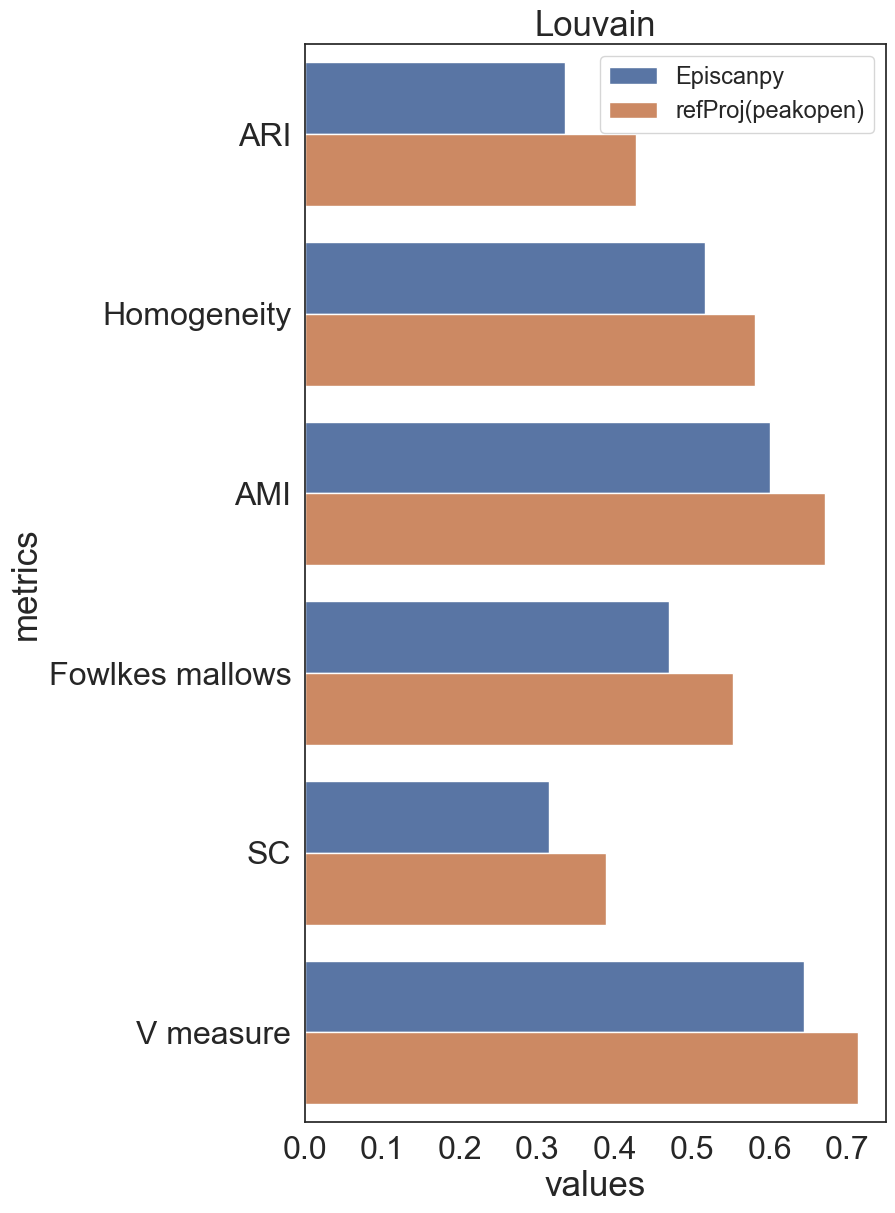

In [19]:
# plot
sns.set_context("notebook", font_scale=2.1)
plt.figure(figsize=(7.5, 14)) 
sns.barplot(y="metrics", x="values", hue="Reduction method",data=data_louvain)
sns.set(style="white")
plt.title('Louvain',fontsize=25)
plt.legend(loc='upper right',fontsize=17)
sns.set_style("white")  # 移除背景网格线

plt.savefig('mca_Cerebellum_62216_%s.png'%'Louvain_240308', dpi=450, bbox_inches='tight')
plt.show()

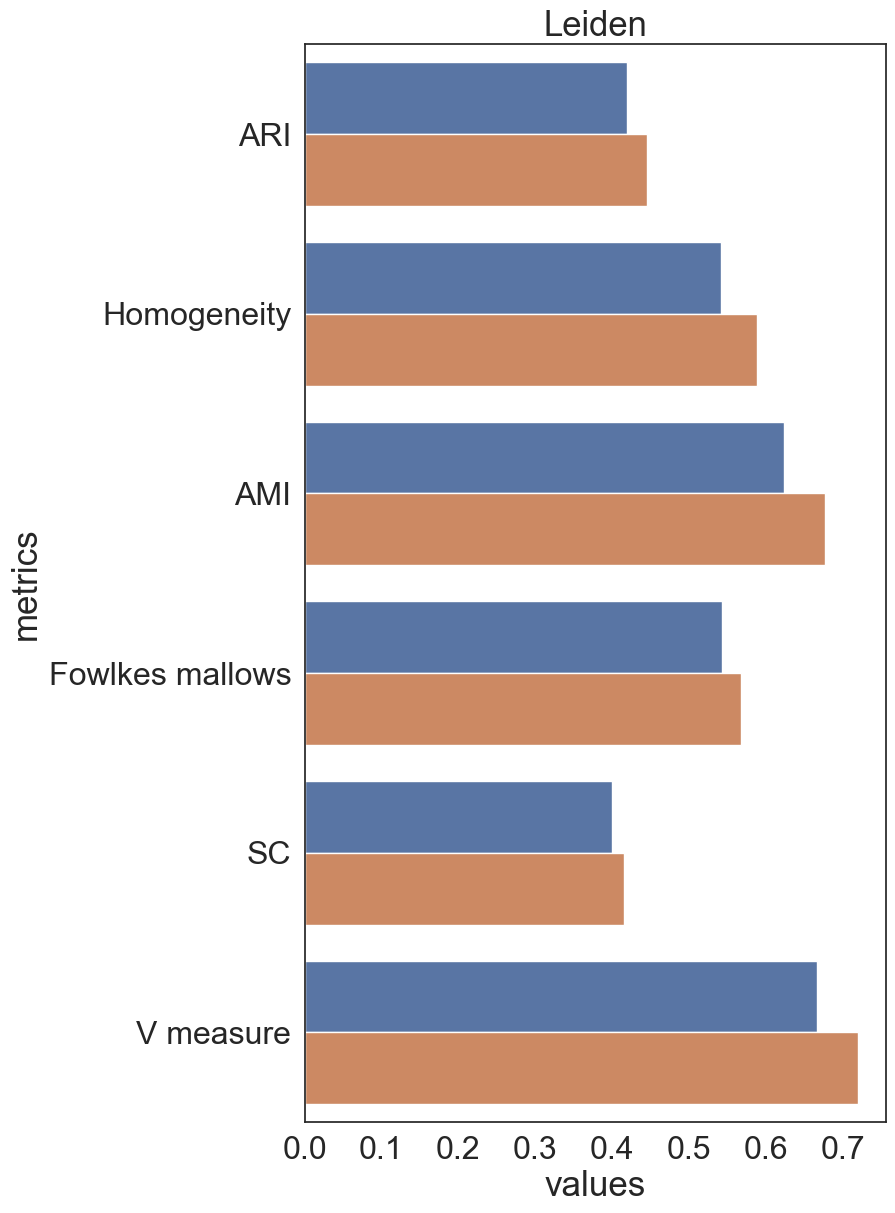

In [23]:
# plot
sns.set_context("notebook", font_scale=2.1)
plt.figure(figsize=(7.5, 14)) 
sns.barplot(y="metrics", x="values", hue="Reduction method",data=data_leiden)
sns.set(style="white")
plt.title('Leiden',fontsize=25)
# plt.legend(loc='upper right',fontsize=17)
sns.set_style("white")  # 移除背景网格线
plt.legend([], frameon=False)

plt.savefig('mca_Cerebellum_62216_%s.png'%'Leiden_240308', dpi=450, bbox_inches='tight')
plt.show()